# Read Data

In [213]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/TokenGT/data/output-dgi-10-10-20MAY2025.h5ad"
)
adata = adata[adata.layers["transcript"].sum(axis=1) > 20].copy()
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])

adata.X = adata.layers["transcript"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
adata.X seems to be already log-transformed.


In [214]:
from scipy.spatial import cKDTree
adata.obs["z_centroid"] = adata.obs["folder"].replace({
    k: i * 10_000
    for i, k in enumerate(adata.obs["folder"].unique())
})

ckd_tree = cKDTree(adata.obs[["x_centroid", "y_centroid", "z_centroid"]])

_, neighbor_indicies = ckd_tree.query(adata.obs[["x_centroid", "y_centroid", "z_centroid"]], k = 31)
neighbor_indicies = neighbor_indicies.tolist()

/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs["z_centroid"] = adata.obs["folder"].replace({
/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["z_centroid"] = adata.obs["folder"].replace({


# Data Set 

In [222]:
import torch

class SpatialSingleCellDataSet:
    
    def __init__(
        self, 
        counts,
        log_normalized,
        plin2_area,
        oil_red_o_area,
        lipid_droplet_area,
        near_amyloid,
        neighbor_indices,
        specimen_ids
    ):
        # Gene Expression Information
        self.counts = self._to_tensor(counts, torch.float)
        self.log_normalized = self._to_tensor(log_normalized, torch.float)

        self.size_factors = (self.counts.sum(axis=1) / self.counts.sum(axis=1).mean()).log()

        # Pathology Information
        self.plin2_area = self._to_tensor(plin2_area, torch.float)
        self.oil_red_o_area = self._to_tensor(oil_red_o_area, torch.float)
        self.lipid_droplet_area = self._to_tensor(lipid_droplet_area, torch.float)
        self.near_amyloid = self._to_tensor(near_amyloid, torch.float)

        # Neighborhood Information
        self.specimen_ids = self._to_tensor(specimen_ids, torch.long)
        self.neighbor_indices = self._to_tensor(neighbor_indices, torch.long)

    @staticmethod
    def _to_tensor(x, dtype=torch.float):
        if isinstance(x, torch.Tensor):
            return x.detach().clone().to(dtype)
        else:
            return torch.tensor(x, dtype=dtype)

    def __len__(self):
        return self.counts.size(0)

    def __getitem__(self, idx):
        return {
            # Expression Information
            "counts": self.counts[idx],
            "log_normalized": self.log_normalized[idx],
            "size_factors": self.size_factors[idx],

            # Pathology Information
            "plin2_area": self.plin2_area[idx],
            "oil_red_o_area": self.oil_red_o_area[idx],
            "lipid_droplet_area": self.lipid_droplet_area[idx],
            "near_amyloid": self.near_amyloid[idx],

            # Neighborhood Information
            "neighbor_indices": self.neighbor_indices[idx],

            # Cell Metadata
            "specimen_ids": self.specimen_ids[idx],
        }

counts = torch.tensor(adata.layers["transcript"])
log_normalized = torch.tensor(adata.X)

plin2_area = torch.tensor(adata.obs["plin2_area"].values).log1p()
oil_red_o_area = torch.tensor(adata.obs["oil_red_o_area"].values).log1p()
lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values).log1p()
near_amyloid = torch.tensor(adata.obs["near_amyloid"].values).float()

neighbor_indices = torch.tensor(neighbor_indicies)
specimen_ids = torch.tensor(adata.obs["folder"].cat.codes.values)

dataset = SpatialSingleCellDataSet(
    counts,
    log_normalized,
    plin2_area,
    oil_red_o_area,
    lipid_droplet_area,
    near_amyloid,
    neighbor_indices,
    specimen_ids
)

input_data = dataset[0]

dataset[input_data["neighbor_indices"]]

{'counts': tensor([[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 1.,  ..., 4., 0., 0.],
         [0., 0., 0.,  ..., 2., 0., 0.],
         ...,
         [1., 0., 2.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'log_normalized': tensor([[0.0000, 0.0000, 1.0282,  ..., 1.0282, 0.0000, 0.0000],
         [0.0000, 0.5346, 0.5346,  ..., 1.3422, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.3048, 0.0000, 0.0000],
         ...,
         [0.2622, 0.0000, 0.4698,  ..., 0.2622, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6243,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'size_factors': tensor([-0.7850,  0.1475, -0.4948,  0.5161, -0.2460, -0.5742, -0.0276, -0.7748,
          0.2358,  0.4046, -0.3593,  0.4678,  0.4412,  0.9418,  0.9048,  0.6938,
         -0.0767,  0.9490, -0.2342, -1.6564,  0.5217, -0.0518,  0.2358,  0.7123,
         -0.0667,  0.5807,  0.2577,  0.4077, 

In [223]:
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

# Gradient Reversal Layer implementation
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Identity forward pass

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

# Variational Encoder (unchanged)
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, embedding_dim)
        self.log_var = nn.Linear(hidden_dim, embedding_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.shared(x)
        log_mu = self.mu(h)
        log_var = self.log_var(h)
        return log_mu, log_var

In [224]:

# Spatial Decoder (same as before, you can copy your existing decoder here)
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_genes, n_batches):
        super().__init__()
        self.batch_emb = nn.Embedding(n_batches, embedding_dim)
        self.shared = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU()
        )
        self.nb_mu = nn.Linear(hidden_dim, n_genes)
        self.log_theta = nn.Parameter(torch.zeros(1))
        self.hurdle_logits = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_mu = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_log_var = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.near_amyloid_logit = nn.Linear(hidden_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z, specimen_ids):
        batch_embedding = self.batch_emb(specimen_ids)
        h = self.shared(torch.cat([z, batch_embedding], dim=-1))
        log_mu_counts = self.nb_mu(h)
        log_theta = self.log_theta.expand_as(log_mu_counts)
        hurdle_out = {}
        for k in self.hurdle_logits.keys():
            hurdle_out[k] = {
                "logit_p": self.hurdle_logits[k](h),
                "mu": self.hurdle_mu[k](h),
                "log_var": self.hurdle_log_var[k](h)
            }
        near_amyloid_logit = self.near_amyloid_logit(h)
        return {
            "log_mu_counts": log_mu_counts,
            "log_theta": log_theta,
            "hurdle": hurdle_out,
            "near_amyloid_logit": near_amyloid_logit
        }

In [225]:
# Discriminator to predict specimen_ids from latent z
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_batches):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_batches)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        return self.net(z)


In [226]:
# Full VAE with adversarial batch correction
class VAEWithAdversarial(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, n_genes, n_batches):
        super().__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, n_genes, n_batches)
        self.discriminator = Discriminator(embedding_dim, hidden_dim // 2, n_batches)

    def reparameterize(self, log_mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return log_mu + eps * std

    def forward(self, input_data):
        x = input_data["log_normalized"]
        specimen_ids = input_data["specimen_ids"]

        log_mu, log_var = self.encoder(x)
        z = self.reparameterize(log_mu, log_var)

        outputs = self.decoder(z, specimen_ids)
        outputs["size_factors"] = input_data["size_factors"]
        return outputs, log_mu, log_var, z

    def discriminate(self, z, lambda_grl=1.0):
        # Apply gradient reversal on z before discriminator
        z_rev = grad_reverse(z, lambda_grl)
        logits = self.discriminator(z_rev)
        return logits


In [235]:
import torch
import torch.nn.functional as F

# 1) Negative Binomial loss for counts

def negative_binomial_loss(x, log_mu, log_theta, size_factors):
    """
    x: observed counts (integer tensor)
    log_mu: decoded log mean (float tensor)
    log_theta: scalar or tensor, shared dispersion (log scale)
    size_factors: tensor, log scale size factors (same shape as batch size)
    """
    # Adjust log_mu by adding size factors (log scale)
    # size_factors shape: (batch_size,)
    # log_mu shape: (batch_size, n_genes)
    log_mu_adj = log_mu + size_factors.unsqueeze(-1)  # broadcast size_factors

    theta = torch.exp(log_theta)  # dispersion

    # logits for NB parameterization: logits = log_mu - log(mu + theta)
    logits = log_mu_adj - torch.log(torch.exp(log_mu_adj) + theta)

    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, logits=logits)
    # Negative log likelihood (sum over genes and batch)
    neg_log_likelihood = -nb_dist.log_prob(x).sum()

    return neg_log_likelihood


# 2) Hurdle normal loss for each pathology feature

def hurdle_normal_loss(x, logit_p, mu, log_var):
    p = torch.sigmoid(logit_p)
    is_zero = (x == 0).float()

    bern_loss = -(is_zero * torch.log(1 - p + 1e-8) + (1 - is_zero) * torch.log(p + 1e-8))

    std = torch.exp(0.5 * log_var)
    const = torch.log(torch.tensor(2 * torch.pi, device=x.device, dtype=x.dtype))
    gaussian_nll = 0.5 * ( ((x - mu) / std) ** 2 + 2 * torch.log(std) + const )
    gaussian_nll = gaussian_nll * (1 - is_zero)

    total_loss = (bern_loss + gaussian_nll).sum()
    return total_loss


# 3) Logistic loss for near_amyloid (binary classification)

def near_amyloid_loss(logits, labels):
    """
    logits: raw logits output from decoder (before sigmoid)
    labels: binary labels (0/1 float tensor)
    """
    loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), labels, reduction='sum')
    return loss


# 4) KL divergence between latent posterior and prior

def kl_divergence(log_mu, log_var):
    """
    Standard VAE KL divergence
    """
    kl = -0.5 * torch.sum(1 + log_var - log_mu.pow(2) - log_var.exp())
    return kl

def discriminator_loss(discriminator_logits, specimen_ids):
    """
    Cross-entropy loss for discriminator predicting specimen_ids.
    """
    return F.cross_entropy(discriminator_logits, specimen_ids)

def compute_total_loss(
    outputs,
    input_data,
    log_mu,
    log_var,
    discriminator_logits=None,
    weight_kl=1.0,
    weight_nb=1.0,
    weight_hurdle=1.0,
    weight_amyloid=1.0,
    weight_adv=0.0,
):
    """
    Computes total loss for VAE model, optionally including adversarial loss.

    If `discriminator_logits` is provided, compute adversarial loss and include weighted in total loss.
    """

    # Negative Binomial loss (counts)
    nb_loss = negative_binomial_loss(
        x=input_data["counts"],
        log_mu=outputs["log_mu_counts"],
        log_theta=outputs["log_theta"],
        size_factors=input_data["size_factors"]
    )

    # Hurdle normal losses (sum over 3 features)
    hurdle_loss = 0.0
    for key in ["plin2", "oil_red_o", "lipid_droplet"]:
        h = outputs["hurdle"][key]
        x = input_data[f"{key}_area"]
        hurdle_loss += hurdle_normal_loss(x, h["logit_p"], h["mu"], h["log_var"])

    # Near amyloid logistic loss
    amyloid_loss = near_amyloid_loss(outputs["near_amyloid_logit"], input_data["near_amyloid"])

    # KL divergence
    kl_loss = kl_divergence(log_mu, log_var)

    # Adversarial loss (optional)
    if discriminator_logits is not None:
        adv_loss = discriminator_loss(discriminator_logits, input_data["specimen_ids"])
    else:
        adv_loss = torch.tensor(0.0, device=log_mu.device)

    # Total loss
    total_loss = (
        weight_nb * nb_loss
        + weight_hurdle * hurdle_loss
        + weight_amyloid * amyloid_loss
        + weight_kl * kl_loss
        + weight_adv * adv_loss
    )

    return total_loss, {
        "total_loss": total_loss.item(),
        "nb_loss": nb_loss.item(),
        "hurdle_loss": hurdle_loss.item(),
        "amyloid_loss": amyloid_loss.item(),
        "kl_loss": kl_loss.item(),
        "adv_loss": adv_loss.item() if isinstance(adv_loss, torch.Tensor) else adv_loss
    }


In [237]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 2048
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

vae = VAE(
    input_dim=366,
    hidden_dim=64,
    embedding_dim=8,
    n_genes=366,
    n_batches=12
).to(device)
vae.train()

discriminator = Discriminator(embedding_dim=8, hidden_dim=32, n_batches=12).to(device)
discriminator.train()

optimizer_vae = Adam(vae.parameters(), lr=1e-3)
optimizer_disc = Adam(discriminator.parameters(), lr=1e-3)

num_epochs = 10
adv_weight = 1.0
lambda_grl = 1.0

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, batch_samples in enumerate(data_loader):
        # Convert list of dicts to dict of batched tensors and send to device
        batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

        # --- Step 1: Train discriminator ---
        for i in range(20):
            optimizer_disc.zero_grad()
            with torch.no_grad():
                log_mu, log_var = vae.encoder(batch_data["log_normalized"])
                z = vae.reparameterize(log_mu, log_var)

            disc_logits = discriminator(z.detach())
            disc_loss = torch.nn.functional.cross_entropy(disc_logits, batch_data["specimen_ids"])
            disc_loss.backward()
            optimizer_disc.step()

        # --- Step 2: Train VAE ---
        optimizer_vae.zero_grad()

        log_mu, log_var = vae.encoder(batch_data["log_normalized"])
        z = vae.reparameterize(log_mu, log_var)

        outputs = vae.decoder(z, batch_data["specimen_ids"])
        outputs["size_factors"] = batch_data["size_factors"]

        z_rev = grad_reverse(z, lambda_grl)
        adv_logits = discriminator(z_rev)

        loss, loss_items = compute_total_loss(
            outputs=outputs,
            input_data=batch_data,
            log_mu=log_mu,
            log_var=log_var,
            discriminator_logits=adv_logits,
            weight_adv=adv_weight
        )

        loss.backward()
        optimizer_vae.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

Using device: cuda
Epoch [1/10], Batch [0], Loss: 84713176.0000, Disc Loss: 2.5941
Epoch [1/10], Batch [10], Loss: 40192312.0000, Disc Loss: 2.4178
Epoch [1/10], Batch [20], Loss: 28667454.0000, Disc Loss: 2.3084
Epoch [1/10], Batch [30], Loss: 29433992.0000, Disc Loss: 2.2302
Epoch [1/10], Batch [40], Loss: 27540956.0000, Disc Loss: 2.2488
Epoch [1/10], Batch [50], Loss: 26322228.0000, Disc Loss: 2.2384
Epoch [1/10], Batch [60], Loss: 24626342.0000, Disc Loss: 2.2220
Epoch [1/10], Batch [70], Loss: 23780822.0000, Disc Loss: 2.2114
Epoch [1/10], Batch [80], Loss: 23753004.0000, Disc Loss: 2.2380
Epoch [1/10], Batch [90], Loss: 23016606.0000, Disc Loss: 2.2180
Epoch [1/10], Batch [100], Loss: 23164608.0000, Disc Loss: 2.2092
Epoch [1/10], Batch [110], Loss: 23189288.0000, Disc Loss: 2.2391
Epoch [1/10], Batch [120], Loss: 23020316.0000, Disc Loss: 2.2167
Epoch [1/10], Batch [130], Loss: 22948774.0000, Disc Loss: 2.2338
Epoch [1/10], Batch [140], Loss: 22731804.0000, Disc Loss: 2.2018
Ep

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75857b01af90>>
Traceback (most recent call last):
  File "/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch [2/10], Batch [100], Loss: 22720974.0000, Disc Loss: 2.1526
Epoch [2/10], Batch [110], Loss: 22161562.0000, Disc Loss: 2.2009
Epoch [2/10], Batch [120], Loss: 22558058.0000, Disc Loss: 2.1915
Epoch [2/10], Batch [130], Loss: 22390692.0000, Disc Loss: 2.1825
Epoch [2/10], Batch [140], Loss: 22045304.0000, Disc Loss: 2.1642
Epoch [2/10], Batch [150], Loss: 22352284.0000, Disc Loss: 2.1780
Epoch [2/10], Batch [160], Loss: 22425240.0000, Disc Loss: 2.1745
Epoch [2/10], Batch [170], Loss: 22532408.0000, Disc Loss: 2.1652
Epoch [2/10], Batch [180], Loss: 22673074.0000, Disc Loss: 2.1872
Epoch [2/10], Batch [190], Loss: 22128932.0000, Disc Loss: 2.1621
Epoch [2/10], Batch [200], Loss: 22197638.0000, Disc Loss: 2.1812
Epoch [2/10], Batch [210], Loss: 22222998.0000, Disc Loss: 2.1538
Epoch [2/10], Batch [220], Loss: 22051152.0000, Disc Loss: 2.1748
Epoch [2/10], Batch [230], Loss: 22370644.0000, Disc Loss: 2.1642
Epoch [2/10], Batch [240], Loss: 22430982.0000, Disc Loss: 2.1362
Epoch [2/1

KeyboardInterrupt: 

In [365]:
import torch
from torch.utils.data import DataLoader

def extract_embeddings(model, dataset, batch_size=256, use_mean=True, device=None):
    """
    Extract latent embeddings for all samples in `dataset`.

    Args:
        model: trained VAE model with encoder
        dataset: dataset object (e.g. SpatialSingleCellDataSet)
        batch_size: batch size for DataLoader
        use_mean: if True, use encoder's mean (log_mu) as embedding,
                  else sample from latent distribution
        device: torch device (e.g. 'cuda' or 'cpu'), default auto-detect

    Returns:
        embeddings: Tensor of shape (n_samples, embedding_dim)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

    all_embeddings = []

    with torch.no_grad():
        for batch_samples in loader:
            batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

            log_mu, log_var = model.encoder(batch_data["log_normalized"])

            if use_mean:
                embeddings = log_mu
            else:
                std = torch.exp(0.5 * log_var)
                eps = torch.randn_like(std)
                embeddings = log_mu + eps * std

            all_embeddings.append(embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

token_embeddings = extract_embeddings(vae, dataset)

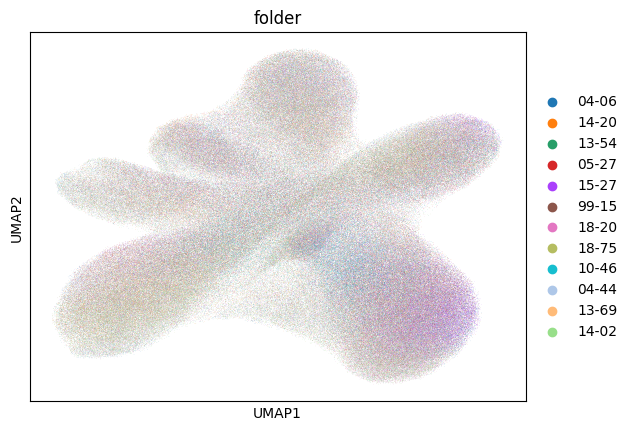

In [239]:
adata.obsm["X_token"] = token_embeddings.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="X_token")
sc.tl.umap(adata)
sc.pl.umap(adata, color="folder")

# Embeddings

In [241]:
import torch
from torch.utils.data import Dataset

class SpatialEmbeddingDataset(Dataset):
    def __init__(self, embeddings, neighbor_indices):
        """
        Args:
            embeddings: Tensor of shape (n_cells, embedding_dim)
            neighbor_indices: LongTensor of shape (n_cells, n_neighbors)
        """
        self.embeddings = embeddings
        self.neighbor_indices = neighbor_indices

    def __len__(self):
        return self.embeddings.size(0)

    def __getitem__(self, idx):
        """
        Returns:
            {
                "center": embedding of center cell (embedding_dim,),
                "neighbors": embeddings of neighbors (n_neighbors, embedding_dim),
                "center_idx": index of the center cell
            }
        """
        center_embedding = self.embeddings[idx]
        neighbor_idxs = self.neighbor_indices[idx]
        neighbor_embeddings = self.embeddings[neighbor_idxs]

        return {
            "center": center_embedding,
            "neighbors": neighbor_embeddings,
            "center_idx": idx
        }

spatial_embedding_dataset = SpatialEmbeddingDataset(
    embeddings=token_embeddings,
    neighbor_indices=neighbor_indices[:, 1:]
)

In [242]:
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

def build_simple_flow(embedding_dim, n_transforms=4, hidden_dim=64):
    base_dist = StandardNormal([embedding_dim])
    transforms = []
    for _ in range(n_transforms):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=embedding_dim,
                hidden_features=hidden_dim
            )
        )
    # Combine into a proper composite transform
    transform = CompositeTransform(transforms)
    return Flow(transform, base_dist)


In [ ]:
class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=6, n_neighbors=30):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional encoding (simple learnable)
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=embedding_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Normalizing Flow for predicting next-token embedding
        self.flow = build_simple_flow(embedding_dim)

    def forward(self, center, neighbors):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        """
        B = center.size(0)
        device = center.device

        # Start with [CLS] + center
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []

        for step in range(neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]

            h = self.transformer(seq)  # (B, seq_len, D)
            context = h[:, -1, :]  # last token representation

            # Predict probability of the next token using the flow
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)  # unconditional for now
            all_log_probs.append(log_prob)

            # Append the ground truth neighbor to the sequence for next step
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, n_neighbors)
        return all_log_probs

def perplexity_loss(log_probs):
    """
    log_probs: (B, n_neighbors), log p(next_token)
    Returns: scalar loss (average perplexity)
    """
    nll = -log_probs  # negative log-likelihood per step
    entropy = nll.mean()  # average entropy across batch & steps
    perplexity = torch.exp(entropy)
    return perplexity

In [311]:
import torch
from tqdm import tqdm
from collections import deque
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

# --- Select device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model & Optimizer ---
model = SpatialTransformerFlow(
    embedding_dim=token_embeddings.size(1),
    n_neighbors=30
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

# --- DataLoader ---
loader = DataLoader(spatial_embedding_dataset, batch_size=4096*2, shuffle=True)

Using device: cuda


In [312]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a logs directory (TensorBoard will read from here)
log_dir = "runs/kanna-chameleon"
writer = SummaryWriter(log_dir=log_dir)

In [313]:
import torch
import numpy as np

def perturb_neighbors_order_fast(neighbors, lam=4):
    """
    neighbors: tensor of shape (B, T) or (B, T, D)
    lam: mean number of swaps per batch element (Poisson)
    
    Returns neighbors with a few swaps applied on tokens [2,...] per batch element.
    """
    neighbors = neighbors.clone()
    shape = neighbors.shape
    batch_size = shape[0]
    n_tokens = shape[1]

    max_swaps = (n_tokens - 2) // 2
    if max_swaps <= 0:
        return neighbors

    # Sample swaps per batch element
    n_swaps_per_batch = np.random.poisson(lam, size=batch_size)
    n_swaps_per_batch = np.clip(n_swaps_per_batch, 0, max_swaps)

    # Allowed indices to swap: 2..n_tokens-1
    allowed_indices = torch.arange(2, n_tokens, device=neighbors.device)

    for i in range(batch_size):
        n_swaps = n_swaps_per_batch[i]
        if n_swaps == 0:
            continue

        # Sample 2 * n_swaps distinct indices without replacement
        # Because each swap swaps 2 tokens
        swap_indices = np.random.choice(allowed_indices.cpu().numpy(), size=2*n_swaps, replace=False)
        swap_indices = torch.tensor(swap_indices, device=neighbors.device)

        # Reshape to pairs
        swap_pairs = swap_indices.view(n_swaps, 2)

        # Swap all pairs at once
        if len(shape) == 3:
            # For embeddings
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp
        else:
            # For indices
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp

        neighbors[i] = neighbors_i

    return neighbors


In [327]:
from tqdm import tqdm
from collections import deque
import numpy as np
import torch

running_losses = deque(maxlen=50)
global_step = 0  # For TensorBoard x-axis

scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler

for epoch in range(1_000):
    model.train()
    total_loss = 0.0
    epoch_pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in epoch_pbar:
        center = batch["center"].to(device, non_blocking=True)
        neighbors = batch["neighbors"].to(device, non_blocking=True)
        # neighbors = perturb_neighbors_order(neighbors)

        optimizer.zero_grad()

        # ✅ Automatic Mixed Precision
        with torch.cuda.amp.autocast():
            log_probs = model(center, neighbors)
            loss = perplexity_loss(log_probs)

        # ✅ Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ---- Tracking ----
        loss_val = loss.item()
        total_loss += loss_val
        running_losses.append(loss_val)
        smooth_loss = np.mean(running_losses)
        global_step += 1

        # Update tqdm bar
        epoch_pbar.set_postfix({
            "batch_loss": f"{loss_val:.4f}",
            "smooth_loss(50)": f"{smooth_loss:.4f}"
        })

        # ---- TensorBoard Logging (optional: log every N steps to reduce overhead) ----
        if global_step % 10 == 0:
            writer.add_scalar("Loss/Batch", loss_val, global_step)
            writer.add_scalar("Loss/Smooth_50", smooth_loss, global_step)

    avg_epoch_loss = total_loss / len(loader)
    writer.add_scalar("Loss/Epoch_Avg", avg_epoch_loss, epoch + 1)
    print(f"Epoch {epoch+1}: Avg Perplexity = {avg_epoch_loss:.4f}")

writer.close()  # Close at the end of training


/tmp/ipykernel_3674434/3466536955.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler
Epoch 1:   0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_3674434/3466536955.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=19335.1035, smooth_loss(50)=19342.2396]


Epoch 1: Avg Perplexity = 19438.2391


Epoch 2: 100%|██████████| 71/71 [00:22<00:00,  3.20it/s, batch_loss=18423.6621, smooth_loss(50)=18570.6151]


Epoch 2: Avg Perplexity = 18682.2789


Epoch 3: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=17615.4082, smooth_loss(50)=17842.6492]


Epoch 3: Avg Perplexity = 17951.6857


Epoch 4: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=16586.7285, smooth_loss(50)=17175.3335]


Epoch 4: Avg Perplexity = 17258.9107


Epoch 5: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=16592.8340, smooth_loss(50)=16501.6331]


Epoch 5: Avg Perplexity = 16610.9647


Epoch 6: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=15747.0107, smooth_loss(50)=15908.4079]


Epoch 6: Avg Perplexity = 15999.4365


Epoch 7: 100%|██████████| 71/71 [00:21<00:00,  3.28it/s, batch_loss=15509.1309, smooth_loss(50)=15345.8107]


Epoch 7: Avg Perplexity = 15425.8519


Epoch 8: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=14835.0898, smooth_loss(50)=14798.6454]


Epoch 8: Avg Perplexity = 14881.2433


Epoch 9: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=14181.1318, smooth_loss(50)=14302.1060]


Epoch 9: Avg Perplexity = 14368.9828


Epoch 10: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=14076.8926, smooth_loss(50)=13808.0032]


Epoch 10: Avg Perplexity = 13886.8123


Epoch 11: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=13165.1406, smooth_loss(50)=13374.7345]


Epoch 11: Avg Perplexity = 13432.1767


Epoch 12: 100%|██████████| 71/71 [00:22<00:00,  3.21it/s, batch_loss=12858.2441, smooth_loss(50)=12952.9403]


Epoch 12: Avg Perplexity = 13002.6311


Epoch 13: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=12238.0107, smooth_loss(50)=12552.7779]


Epoch 13: Avg Perplexity = 12592.2192


Epoch 14: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=11920.7734, smooth_loss(50)=12152.3412]


Epoch 14: Avg Perplexity = 12204.7237


Epoch 15: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=11649.3174, smooth_loss(50)=11768.4898]


Epoch 15: Avg Perplexity = 11820.1592


Epoch 16: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=11139.5098, smooth_loss(50)=11368.1378]


Epoch 16: Avg Perplexity = 11434.6204


Epoch 17: 100%|██████████| 71/71 [00:21<00:00,  3.27it/s, batch_loss=10995.5127, smooth_loss(50)=10993.6719]


Epoch 17: Avg Perplexity = 11062.3392


Epoch 18: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=10422.8994, smooth_loss(50)=10658.8030]


Epoch 18: Avg Perplexity = 10699.6854


Epoch 19: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=10246.0723, smooth_loss(50)=10314.3493]


Epoch 19: Avg Perplexity = 10354.7998


Epoch 20: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=10019.5234, smooth_loss(50)=9996.1915] 


Epoch 20: Avg Perplexity = 10031.6221


Epoch 21: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=9701.2305, smooth_loss(50)=9686.0870]


Epoch 21: Avg Perplexity = 9729.3965


Epoch 22: 100%|██████████| 71/71 [00:22<00:00,  3.21it/s, batch_loss=9205.9336, smooth_loss(50)=9411.7859]


Epoch 22: Avg Perplexity = 9446.0803


Epoch 23: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=9127.3438, smooth_loss(50)=9151.5836]


Epoch 23: Avg Perplexity = 9180.8688


Epoch 24: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=8783.0645, smooth_loss(50)=8879.0990]


Epoch 24: Avg Perplexity = 8928.6848


Epoch 25: 100%|██████████| 71/71 [00:22<00:00,  3.20it/s, batch_loss=8647.7627, smooth_loss(50)=8656.2633]


Epoch 25: Avg Perplexity = 8695.0832


Epoch 26: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=8522.0332, smooth_loss(50)=8439.2968]


Epoch 26: Avg Perplexity = 8473.9451


Epoch 27: 100%|██████████| 71/71 [00:21<00:00,  3.23it/s, batch_loss=8270.4951, smooth_loss(50)=8237.6690]


Epoch 27: Avg Perplexity = 8263.8766


Epoch 28: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=8068.1685, smooth_loss(50)=8039.5820]


Epoch 28: Avg Perplexity = 8066.7920


Epoch 29: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=7755.4346, smooth_loss(50)=7847.0344]


Epoch 29: Avg Perplexity = 7879.1761


Epoch 30: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=7505.2925, smooth_loss(50)=7666.5324]


Epoch 30: Avg Perplexity = 7699.4938


Epoch 31: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=7403.4429, smooth_loss(50)=7515.5979]


Epoch 31: Avg Perplexity = 7530.7107


Epoch 32: 100%|██████████| 71/71 [00:21<00:00,  3.23it/s, batch_loss=7147.9878, smooth_loss(50)=7340.0632]


Epoch 32: Avg Perplexity = 7369.5668


Epoch 33: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=7106.4307, smooth_loss(50)=7197.1263]


Epoch 33: Avg Perplexity = 7214.4867


Epoch 34: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=7060.9526, smooth_loss(50)=7055.0813]


Epoch 34: Avg Perplexity = 7067.2123


Epoch 35: 100%|██████████| 71/71 [00:22<00:00,  3.21it/s, batch_loss=6817.5425, smooth_loss(50)=6908.1931]


Epoch 35: Avg Perplexity = 6925.2389


Epoch 36: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=6712.7808, smooth_loss(50)=6773.3055]


Epoch 36: Avg Perplexity = 6788.3245


Epoch 37: 100%|██████████| 71/71 [00:22<00:00,  3.21it/s, batch_loss=6479.7969, smooth_loss(50)=6632.9952]


Epoch 37: Avg Perplexity = 6655.9428


Epoch 38: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=6495.6299, smooth_loss(50)=6513.8829]


Epoch 38: Avg Perplexity = 6528.2971


Epoch 39: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=6338.6509, smooth_loss(50)=6386.6026]


Epoch 39: Avg Perplexity = 6406.0395


Epoch 40: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=6237.8687, smooth_loss(50)=6264.5382]


Epoch 40: Avg Perplexity = 6286.9292


Epoch 41: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=6083.8223, smooth_loss(50)=6162.1691]


Epoch 41: Avg Perplexity = 6169.9042


Epoch 42: 100%|██████████| 71/71 [00:22<00:00,  3.21it/s, batch_loss=5876.1924, smooth_loss(50)=6038.7441]


Epoch 42: Avg Perplexity = 6056.8014


Epoch 43: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5830.0181, smooth_loss(50)=5929.9889]


Epoch 43: Avg Perplexity = 5947.4896


Epoch 44: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5916.9844, smooth_loss(50)=5819.9364]


Epoch 44: Avg Perplexity = 5842.2039


Epoch 45: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=5631.2217, smooth_loss(50)=5721.6904]


Epoch 45: Avg Perplexity = 5737.9236


Epoch 46: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5631.7158, smooth_loss(50)=5620.9417]


Epoch 46: Avg Perplexity = 5636.9054


Epoch 47: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5355.4282, smooth_loss(50)=5518.2794]


Epoch 47: Avg Perplexity = 5536.7701


Epoch 48: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5499.8257, smooth_loss(50)=5429.8460]


Epoch 48: Avg Perplexity = 5441.0876


Epoch 49: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=5294.9546, smooth_loss(50)=5329.6213]


Epoch 49: Avg Perplexity = 5347.0553


Epoch 50: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5193.8975, smooth_loss(50)=5241.9238]


Epoch 50: Avg Perplexity = 5254.9804


Epoch 51: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5126.1904, smooth_loss(50)=5151.6690]


Epoch 51: Avg Perplexity = 5164.5928


Epoch 52: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4987.3921, smooth_loss(50)=5069.8926]


Epoch 52: Avg Perplexity = 5076.0549


Epoch 53: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=4954.9785, smooth_loss(50)=4977.7050]


Epoch 53: Avg Perplexity = 4989.4592


Epoch 54: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=4739.8213, smooth_loss(50)=4890.6457]


Epoch 54: Avg Perplexity = 4903.8671


Epoch 55: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=4724.5044, smooth_loss(50)=4807.7619]


Epoch 55: Avg Perplexity = 4820.4827


Epoch 56: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=4777.5381, smooth_loss(50)=4717.8015]


Epoch 56: Avg Perplexity = 4737.1221


Epoch 57: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4572.9580, smooth_loss(50)=4638.8610]


Epoch 57: Avg Perplexity = 4653.3601


Epoch 58: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=4632.9824, smooth_loss(50)=4558.8544]


Epoch 58: Avg Perplexity = 4571.5014


Epoch 59: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=4540.8037, smooth_loss(50)=4475.1291]


Epoch 59: Avg Perplexity = 4491.0995


Epoch 60: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4364.3589, smooth_loss(50)=4402.2784]


Epoch 60: Avg Perplexity = 4412.0607


Epoch 61: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4296.5151, smooth_loss(50)=4328.1705]


Epoch 61: Avg Perplexity = 4335.1952


Epoch 62: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4118.2480, smooth_loss(50)=4251.5751]


Epoch 62: Avg Perplexity = 4258.9097


Epoch 63: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=4098.3208, smooth_loss(50)=4176.7734]


Epoch 63: Avg Perplexity = 4183.7204


Epoch 64: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=4074.0474, smooth_loss(50)=4101.4509]


Epoch 64: Avg Perplexity = 4110.4245


Epoch 65: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4005.9348, smooth_loss(50)=4030.2937]


Epoch 65: Avg Perplexity = 4037.1029


Epoch 66: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=3953.9138, smooth_loss(50)=3950.7004]


Epoch 66: Avg Perplexity = 3965.4461


Epoch 67: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=3876.1960, smooth_loss(50)=3886.5320]


Epoch 67: Avg Perplexity = 3893.9180


Epoch 68: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=3766.8862, smooth_loss(50)=3805.4021]


Epoch 68: Avg Perplexity = 3818.3681


Epoch 69: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=3640.8142, smooth_loss(50)=3697.8234]


Epoch 69: Avg Perplexity = 3719.3248


Epoch 70: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=3613.0015, smooth_loss(50)=3592.4744]


Epoch 70: Avg Perplexity = 3612.2435


Epoch 71: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=3414.0498, smooth_loss(50)=3494.3825]


Epoch 71: Avg Perplexity = 3504.6838


Epoch 72: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=3289.1074, smooth_loss(50)=3378.6496]


Epoch 72: Avg Perplexity = 3399.3327


Epoch 73: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=3308.8589, smooth_loss(50)=3282.3968]


Epoch 73: Avg Perplexity = 3296.2037


Epoch 74: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=3128.4773, smooth_loss(50)=3181.0739]


Epoch 74: Avg Perplexity = 3195.4264


Epoch 75: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=3098.3818, smooth_loss(50)=3080.1784]


Epoch 75: Avg Perplexity = 3097.5063


Epoch 76: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=2976.6272, smooth_loss(50)=2987.3226]


Epoch 76: Avg Perplexity = 3002.5918


Epoch 77: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=2787.0813, smooth_loss(50)=2896.3063]


Epoch 77: Avg Perplexity = 2909.2707


Epoch 78: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=2775.5615, smooth_loss(50)=2809.1226]


Epoch 78: Avg Perplexity = 2819.5922


Epoch 79: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=2729.7136, smooth_loss(50)=2718.9742]


Epoch 79: Avg Perplexity = 2732.0426


Epoch 80: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=2599.7390, smooth_loss(50)=2635.6961]


Epoch 80: Avg Perplexity = 2646.1974


Epoch 81: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=2537.5142, smooth_loss(50)=2553.0021]


Epoch 81: Avg Perplexity = 2562.2134


Epoch 82: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=2505.7229, smooth_loss(50)=2466.2525]


Epoch 82: Avg Perplexity = 2479.2946


Epoch 83: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=2332.1797, smooth_loss(50)=2390.0325]


Epoch 83: Avg Perplexity = 2398.4855


Epoch 84: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=2275.3884, smooth_loss(50)=2309.3441]


Epoch 84: Avg Perplexity = 2320.3035


Epoch 85: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=2186.4434, smooth_loss(50)=2233.5997]


Epoch 85: Avg Perplexity = 2244.0891


Epoch 86: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=2140.4805, smooth_loss(50)=2159.2753]


Epoch 86: Avg Perplexity = 2170.2583


Epoch 87: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=2002.1633, smooth_loss(50)=2088.8149]


Epoch 87: Avg Perplexity = 2098.3850


Epoch 88: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=1986.9784, smooth_loss(50)=2016.4416]


Epoch 88: Avg Perplexity = 2029.0033


Epoch 89: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=1916.7417, smooth_loss(50)=1951.6049]


Epoch 89: Avg Perplexity = 1961.4917


Epoch 90: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=1865.1023, smooth_loss(50)=1886.5782]


Epoch 90: Avg Perplexity = 1896.1041


Epoch 91: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=1810.6738, smooth_loss(50)=1822.1003]


Epoch 91: Avg Perplexity = 1832.9000


Epoch 92: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=1735.1876, smooth_loss(50)=1763.1144]


Epoch 92: Avg Perplexity = 1771.3565


Epoch 93: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=1678.9946, smooth_loss(50)=1704.8210]


Epoch 93: Avg Perplexity = 1711.7926


Epoch 94: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=1596.5059, smooth_loss(50)=1644.9371]


Epoch 94: Avg Perplexity = 1654.2192


Epoch 95: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=1568.3853, smooth_loss(50)=1592.7417]


Epoch 95: Avg Perplexity = 1598.3056


Epoch 96: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=1551.3397, smooth_loss(50)=1536.8070]


Epoch 96: Avg Perplexity = 1542.6662


Epoch 97: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=1430.9532, smooth_loss(50)=1478.1693]


Epoch 97: Avg Perplexity = 1487.4644


Epoch 98: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=1427.0549, smooth_loss(50)=1423.3628]


Epoch 98: Avg Perplexity = 1432.4283


Epoch 99: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=1348.4908, smooth_loss(50)=1369.6360]


Epoch 99: Avg Perplexity = 1374.8926


Epoch 100: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=1276.9105, smooth_loss(50)=1307.1017]


Epoch 100: Avg Perplexity = 1315.1916


Epoch 101: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=1195.5771, smooth_loss(50)=1249.1481]


Epoch 101: Avg Perplexity = 1256.7421


Epoch 102: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=1189.1324, smooth_loss(50)=1194.3744]


Epoch 102: Avg Perplexity = 1201.2248


Epoch 103: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=1118.0964, smooth_loss(50)=1142.0263]


Epoch 103: Avg Perplexity = 1148.9386


Epoch 104: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=1058.6011, smooth_loss(50)=1093.0805]


Epoch 104: Avg Perplexity = 1099.7856


Epoch 105: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=1019.2488, smooth_loss(50)=1046.5938]


Epoch 105: Avg Perplexity = 1053.6662


Epoch 106: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=972.0895, smooth_loss(50)=1003.2009] 


Epoch 106: Avg Perplexity = 1010.3346


Epoch 107: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=952.0602, smooth_loss(50)=962.5111] 


Epoch 107: Avg Perplexity = 969.5623


Epoch 108: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=914.8162, smooth_loss(50)=925.2773]


Epoch 108: Avg Perplexity = 930.7437


Epoch 109: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=863.8682, smooth_loss(50)=887.4674]


Epoch 109: Avg Perplexity = 893.4390


Epoch 110: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=855.4670, smooth_loss(50)=853.7460]


Epoch 110: Avg Perplexity = 858.1483


Epoch 111: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=817.6051, smooth_loss(50)=820.2665]


Epoch 111: Avg Perplexity = 824.8076


Epoch 112: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=781.3813, smooth_loss(50)=788.2745]


Epoch 112: Avg Perplexity = 793.4490


Epoch 113: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=741.1164, smooth_loss(50)=760.4162]


Epoch 113: Avg Perplexity = 763.9233


Epoch 114: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=704.4923, smooth_loss(50)=730.2345]


Epoch 114: Avg Perplexity = 735.9311


Epoch 115: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=687.7664, smooth_loss(50)=704.5104]


Epoch 115: Avg Perplexity = 708.8748


Epoch 116: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=671.4377, smooth_loss(50)=680.1067]


Epoch 116: Avg Perplexity = 683.2480


Epoch 117: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=639.1845, smooth_loss(50)=655.4282]


Epoch 117: Avg Perplexity = 659.3385


Epoch 118: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=629.4237, smooth_loss(50)=634.3718]


Epoch 118: Avg Perplexity = 637.0334


Epoch 119: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=608.3755, smooth_loss(50)=614.2622]


Epoch 119: Avg Perplexity = 616.2385


Epoch 120: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=596.1279, smooth_loss(50)=595.1527]


Epoch 120: Avg Perplexity = 596.8875


Epoch 121: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=572.6625, smooth_loss(50)=575.2237]


Epoch 121: Avg Perplexity = 578.7153


Epoch 122: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=546.2203, smooth_loss(50)=559.3447]


Epoch 122: Avg Perplexity = 561.5909


Epoch 123: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=539.1690, smooth_loss(50)=542.9411]


Epoch 123: Avg Perplexity = 545.2745


Epoch 124: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=527.8837, smooth_loss(50)=527.7445]


Epoch 124: Avg Perplexity = 529.8760


Epoch 125: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=507.9703, smooth_loss(50)=513.1289]


Epoch 125: Avg Perplexity = 515.1020


Epoch 126: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=490.0627, smooth_loss(50)=499.2914]


Epoch 126: Avg Perplexity = 501.1066


Epoch 127: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=481.8796, smooth_loss(50)=486.0669]


Epoch 127: Avg Perplexity = 487.8628


Epoch 128: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=474.3249, smooth_loss(50)=473.5576]


Epoch 128: Avg Perplexity = 475.0724


Epoch 129: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=452.0197, smooth_loss(50)=460.8172]


Epoch 129: Avg Perplexity = 462.8658


Epoch 130: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=443.3590, smooth_loss(50)=449.7281]


Epoch 130: Avg Perplexity = 451.1105


Epoch 131: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=442.8038, smooth_loss(50)=438.8252]


Epoch 131: Avg Perplexity = 439.7649


Epoch 132: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=419.0495, smooth_loss(50)=426.8136]


Epoch 132: Avg Perplexity = 428.7523


Epoch 133: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=407.3055, smooth_loss(50)=416.4606]


Epoch 133: Avg Perplexity = 418.1860


Epoch 134: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=401.3364, smooth_loss(50)=406.7465]


Epoch 134: Avg Perplexity = 407.8739


Epoch 135: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=395.2672, smooth_loss(50)=396.7513]


Epoch 135: Avg Perplexity = 397.8529


Epoch 136: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=380.5202, smooth_loss(50)=386.5647]


Epoch 136: Avg Perplexity = 387.9891


Epoch 137: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=372.7680, smooth_loss(50)=375.8668]


Epoch 137: Avg Perplexity = 378.1828


Epoch 138: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=361.7777, smooth_loss(50)=366.9597]


Epoch 138: Avg Perplexity = 368.5368


Epoch 139: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=347.5769, smooth_loss(50)=358.1266]


Epoch 139: Avg Perplexity = 359.2377


Epoch 140: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=349.4655, smooth_loss(50)=348.8809]


Epoch 140: Avg Perplexity = 350.3503


Epoch 141: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=342.9071, smooth_loss(50)=339.9850]


Epoch 141: Avg Perplexity = 341.5583


Epoch 142: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=329.8176, smooth_loss(50)=331.5597]


Epoch 142: Avg Perplexity = 332.6068


Epoch 143: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=313.5507, smooth_loss(50)=322.4571]


Epoch 143: Avg Perplexity = 323.8213


Epoch 144: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=309.6292, smooth_loss(50)=313.7881]


Epoch 144: Avg Perplexity = 315.2104


Epoch 145: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=299.3150, smooth_loss(50)=305.4687]


Epoch 145: Avg Perplexity = 306.7726


Epoch 146: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=300.6494, smooth_loss(50)=297.3359]


Epoch 146: Avg Perplexity = 298.5939


Epoch 147: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=286.8705, smooth_loss(50)=289.5650]


Epoch 147: Avg Perplexity = 290.5072


Epoch 148: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=277.2989, smooth_loss(50)=281.2112]


Epoch 148: Avg Perplexity = 282.3849


Epoch 149: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=275.6709, smooth_loss(50)=272.7716]


Epoch 149: Avg Perplexity = 274.3135


Epoch 150: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=266.3190, smooth_loss(50)=265.1375]


Epoch 150: Avg Perplexity = 266.3382


Epoch 151: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=256.1057, smooth_loss(50)=257.6071]


Epoch 151: Avg Perplexity = 258.5608


Epoch 152: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=248.2672, smooth_loss(50)=249.8145]


Epoch 152: Avg Perplexity = 250.9624


Epoch 153: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=237.0733, smooth_loss(50)=242.4885]


Epoch 153: Avg Perplexity = 243.5449


Epoch 154: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=234.6600, smooth_loss(50)=235.4963]


Epoch 154: Avg Perplexity = 236.2937


Epoch 155: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=229.6904, smooth_loss(50)=228.0983]


Epoch 155: Avg Perplexity = 229.1683


Epoch 156: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=220.9482, smooth_loss(50)=220.9508]


Epoch 156: Avg Perplexity = 222.1772


Epoch 157: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=208.9556, smooth_loss(50)=214.3895]


Epoch 157: Avg Perplexity = 215.3806


Epoch 158: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=208.6593, smooth_loss(50)=207.6617]


Epoch 158: Avg Perplexity = 208.8003


Epoch 159: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=200.6530, smooth_loss(50)=201.3393]


Epoch 159: Avg Perplexity = 202.4214


Epoch 160: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=197.2783, smooth_loss(50)=195.4424]


Epoch 160: Avg Perplexity = 196.1978


Epoch 161: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=187.1859, smooth_loss(50)=188.9754]


Epoch 161: Avg Perplexity = 190.1304


Epoch 162: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=182.3468, smooth_loss(50)=183.2277]


Epoch 162: Avg Perplexity = 184.2738


Epoch 163: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=174.3297, smooth_loss(50)=177.8602]


Epoch 163: Avg Perplexity = 178.6518


Epoch 164: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=169.4907, smooth_loss(50)=172.7112]


Epoch 164: Avg Perplexity = 173.2696


Epoch 165: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=167.4713, smooth_loss(50)=167.0607]


Epoch 165: Avg Perplexity = 168.0955


Epoch 166: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=162.4821, smooth_loss(50)=162.6107]


Epoch 166: Avg Perplexity = 163.1483


Epoch 167: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=155.7670, smooth_loss(50)=157.7351]


Epoch 167: Avg Perplexity = 158.4074


Epoch 168: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=153.0891, smooth_loss(50)=153.2566]


Epoch 168: Avg Perplexity = 153.8815


Epoch 169: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=149.1747, smooth_loss(50)=148.8538]


Epoch 169: Avg Perplexity = 149.5549


Epoch 170: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=142.1942, smooth_loss(50)=144.8352]


Epoch 170: Avg Perplexity = 145.3740


Epoch 171: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=139.4232, smooth_loss(50)=140.6788]


Epoch 171: Avg Perplexity = 141.3203


Epoch 172: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=138.3590, smooth_loss(50)=137.0420]


Epoch 172: Avg Perplexity = 137.4541


Epoch 173: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=131.5615, smooth_loss(50)=133.3534]


Epoch 173: Avg Perplexity = 133.7430


Epoch 174: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=129.5815, smooth_loss(50)=129.6793]


Epoch 174: Avg Perplexity = 130.2218


Epoch 175: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=126.2464, smooth_loss(50)=126.4639]


Epoch 175: Avg Perplexity = 126.8486


Epoch 176: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=123.3205, smooth_loss(50)=123.1485]


Epoch 176: Avg Perplexity = 123.6152


Epoch 177: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=118.5436, smooth_loss(50)=120.0223]


Epoch 177: Avg Perplexity = 120.5154


Epoch 178: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=115.9430, smooth_loss(50)=117.1257]


Epoch 178: Avg Perplexity = 117.5739


Epoch 179: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=115.3506, smooth_loss(50)=114.2834]


Epoch 179: Avg Perplexity = 114.7470


Epoch 180: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=110.2368, smooth_loss(50)=111.6393]


Epoch 180: Avg Perplexity = 112.0075


Epoch 181: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=109.2840, smooth_loss(50)=109.0297]


Epoch 181: Avg Perplexity = 109.3511


Epoch 182: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=105.6441, smooth_loss(50)=106.4424]


Epoch 182: Avg Perplexity = 106.6911


Epoch 183: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=104.5941, smooth_loss(50)=103.6327]


Epoch 183: Avg Perplexity = 104.0105


Epoch 184: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=103.2713, smooth_loss(50)=101.1389]


Epoch 184: Avg Perplexity = 101.3728


Epoch 185: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=99.4409, smooth_loss(50)=98.4384]  


Epoch 185: Avg Perplexity = 98.8138


Epoch 186: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=94.9629, smooth_loss(50)=95.9726]


Epoch 186: Avg Perplexity = 96.3444


Epoch 187: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=94.2137, smooth_loss(50)=93.7459]


Epoch 187: Avg Perplexity = 94.0132


Epoch 188: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=91.0840, smooth_loss(50)=91.4329]


Epoch 188: Avg Perplexity = 91.7742


Epoch 189: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=88.0076, smooth_loss(50)=89.1658]


Epoch 189: Avg Perplexity = 89.5771


Epoch 190: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=87.2541, smooth_loss(50)=87.1400]


Epoch 190: Avg Perplexity = 87.4650


Epoch 191: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=83.5641, smooth_loss(50)=85.1953]


Epoch 191: Avg Perplexity = 85.4443


Epoch 192: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=83.5900, smooth_loss(50)=83.2013]


Epoch 192: Avg Perplexity = 83.5329


Epoch 193: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=81.6430, smooth_loss(50)=81.4713]


Epoch 193: Avg Perplexity = 81.7184


Epoch 194: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=78.7319, smooth_loss(50)=79.6893]


Epoch 194: Avg Perplexity = 79.9861


Epoch 195: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=77.8067, smooth_loss(50)=78.0842]


Epoch 195: Avg Perplexity = 78.3651


Epoch 196: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=76.3118, smooth_loss(50)=76.6186]


Epoch 196: Avg Perplexity = 76.8338


Epoch 197: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=74.5945, smooth_loss(50)=75.2880]


Epoch 197: Avg Perplexity = 75.3941


Epoch 198: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=73.3802, smooth_loss(50)=73.9328]


Epoch 198: Avg Perplexity = 74.0372


Epoch 199: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=73.2516, smooth_loss(50)=72.6227]


Epoch 199: Avg Perplexity = 72.7619


Epoch 200: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=70.0935, smooth_loss(50)=71.3778]


Epoch 200: Avg Perplexity = 71.5470


Epoch 201: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=70.8863, smooth_loss(50)=70.2497]


Epoch 201: Avg Perplexity = 70.4198


Epoch 202: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=69.7824, smooth_loss(50)=69.2725]


Epoch 202: Avg Perplexity = 69.3570


Epoch 203: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=67.8500, smooth_loss(50)=68.2380]


Epoch 203: Avg Perplexity = 68.3538


Epoch 204: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=66.1400, smooth_loss(50)=67.4346]


Epoch 204: Avg Perplexity = 67.4099


Epoch 205: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=65.5649, smooth_loss(50)=66.4323]


Epoch 205: Avg Perplexity = 66.5255


Epoch 206: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=65.4528, smooth_loss(50)=65.5094]


Epoch 206: Avg Perplexity = 65.6931


Epoch 207: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=65.6922, smooth_loss(50)=64.8206]


Epoch 207: Avg Perplexity = 64.9099


Epoch 208: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=63.6866, smooth_loss(50)=64.0395]


Epoch 208: Avg Perplexity = 64.1666


Epoch 209: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=63.1828, smooth_loss(50)=63.2650]


Epoch 209: Avg Perplexity = 63.4557


Epoch 210: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=62.8511, smooth_loss(50)=62.6924]


Epoch 210: Avg Perplexity = 62.7753


Epoch 211: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=62.8808, smooth_loss(50)=61.9230]


Epoch 211: Avg Perplexity = 62.1266


Epoch 212: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=61.4697, smooth_loss(50)=61.3166]


Epoch 212: Avg Perplexity = 61.4936


Epoch 213: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=61.1826, smooth_loss(50)=60.8108]


Epoch 213: Avg Perplexity = 60.8834


Epoch 214: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=61.2089, smooth_loss(50)=60.1964]


Epoch 214: Avg Perplexity = 60.2909


Epoch 215: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=61.2843, smooth_loss(50)=59.6461]


Epoch 215: Avg Perplexity = 59.7151


Epoch 216: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=60.3694, smooth_loss(50)=59.1027]


Epoch 216: Avg Perplexity = 59.1511


Epoch 217: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=58.3455, smooth_loss(50)=58.6159]


Epoch 217: Avg Perplexity = 58.6054


Epoch 218: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=59.5742, smooth_loss(50)=58.0398]


Epoch 218: Avg Perplexity = 58.0873


Epoch 219: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=57.1248, smooth_loss(50)=57.4167]


Epoch 219: Avg Perplexity = 57.5683


Epoch 220: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=56.0571, smooth_loss(50)=56.8533]


Epoch 220: Avg Perplexity = 57.0763


Epoch 221: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=56.6391, smooth_loss(50)=56.5666]


Epoch 221: Avg Perplexity = 56.5987


Epoch 222: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=55.4186, smooth_loss(50)=56.0732]


Epoch 222: Avg Perplexity = 56.1278


Epoch 223: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=55.4140, smooth_loss(50)=55.6058]


Epoch 223: Avg Perplexity = 55.6677


Epoch 224: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=54.0102, smooth_loss(50)=55.1925]


Epoch 224: Avg Perplexity = 55.2161


Epoch 225: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=54.1967, smooth_loss(50)=54.6525]


Epoch 225: Avg Perplexity = 54.7813


Epoch 226: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=54.1113, smooth_loss(50)=54.2596]


Epoch 226: Avg Perplexity = 54.3547


Epoch 227: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=53.6993, smooth_loss(50)=53.8779]


Epoch 227: Avg Perplexity = 53.9369


Epoch 228: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=53.3408, smooth_loss(50)=53.4451]


Epoch 228: Avg Perplexity = 53.5277


Epoch 229: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=53.9690, smooth_loss(50)=53.0741]


Epoch 229: Avg Perplexity = 53.1337


Epoch 230: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=51.8661, smooth_loss(50)=52.6509]


Epoch 230: Avg Perplexity = 52.7340


Epoch 231: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=51.5248, smooth_loss(50)=52.3305]


Epoch 231: Avg Perplexity = 52.3493


Epoch 232: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=51.9580, smooth_loss(50)=51.7807]


Epoch 232: Avg Perplexity = 51.9733


Epoch 233: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=51.8439, smooth_loss(50)=51.4958]


Epoch 233: Avg Perplexity = 51.6045


Epoch 234: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=51.4823, smooth_loss(50)=51.1428]


Epoch 234: Avg Perplexity = 51.2372


Epoch 235: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=49.9275, smooth_loss(50)=50.8545]


Epoch 235: Avg Perplexity = 50.8716


Epoch 236: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=51.5113, smooth_loss(50)=50.4677]


Epoch 236: Avg Perplexity = 50.5217


Epoch 237: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=49.4947, smooth_loss(50)=50.1462]


Epoch 237: Avg Perplexity = 50.1666


Epoch 238: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=50.5514, smooth_loss(50)=49.7484]


Epoch 238: Avg Perplexity = 49.8220


Epoch 239: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=50.3764, smooth_loss(50)=49.4007]


Epoch 239: Avg Perplexity = 49.4774


Epoch 240: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=49.7840, smooth_loss(50)=49.0362]


Epoch 240: Avg Perplexity = 49.1360


Epoch 241: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=47.7348, smooth_loss(50)=48.6759]


Epoch 241: Avg Perplexity = 48.7893


Epoch 242: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=48.7720, smooth_loss(50)=48.3478]


Epoch 242: Avg Perplexity = 48.4468


Epoch 243: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=47.8303, smooth_loss(50)=48.0662]


Epoch 243: Avg Perplexity = 48.1044


Epoch 244: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=48.2568, smooth_loss(50)=47.7616]


Epoch 244: Avg Perplexity = 47.7681


Epoch 245: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=47.6175, smooth_loss(50)=47.3572]


Epoch 245: Avg Perplexity = 47.4255


Epoch 246: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=46.8538, smooth_loss(50)=47.0159]


Epoch 246: Avg Perplexity = 47.0780


Epoch 247: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=47.0536, smooth_loss(50)=46.6842]


Epoch 247: Avg Perplexity = 46.7332


Epoch 248: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=46.7138, smooth_loss(50)=46.3984]


Epoch 248: Avg Perplexity = 46.3915


Epoch 249: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=44.7088, smooth_loss(50)=45.9964]


Epoch 249: Avg Perplexity = 46.0455


Epoch 250: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=45.8472, smooth_loss(50)=45.6457]


Epoch 250: Avg Perplexity = 45.7166


Epoch 251: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=44.5285, smooth_loss(50)=45.3846]


Epoch 251: Avg Perplexity = 45.3815


Epoch 252: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=45.9848, smooth_loss(50)=44.9998]


Epoch 252: Avg Perplexity = 45.0562


Epoch 253: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=44.9446, smooth_loss(50)=44.7399]


Epoch 253: Avg Perplexity = 44.7360


Epoch 254: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=44.0824, smooth_loss(50)=44.3616]


Epoch 254: Avg Perplexity = 44.4070


Epoch 255: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=44.2560, smooth_loss(50)=44.0093]


Epoch 255: Avg Perplexity = 44.0865


Epoch 256: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=43.6182, smooth_loss(50)=43.7414]


Epoch 256: Avg Perplexity = 43.7760


Epoch 257: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=42.6188, smooth_loss(50)=43.4063]


Epoch 257: Avg Perplexity = 43.4571


Epoch 258: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=43.4153, smooth_loss(50)=43.0961]


Epoch 258: Avg Perplexity = 43.1482


Epoch 259: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=43.1809, smooth_loss(50)=42.7811]


Epoch 259: Avg Perplexity = 42.8413


Epoch 260: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=43.1169, smooth_loss(50)=42.4764]


Epoch 260: Avg Perplexity = 42.5355


Epoch 261: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=42.5573, smooth_loss(50)=42.2328]


Epoch 261: Avg Perplexity = 42.2291


Epoch 262: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=41.9293, smooth_loss(50)=41.8206]


Epoch 262: Avg Perplexity = 41.9235


Epoch 263: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=42.4963, smooth_loss(50)=41.5987]


Epoch 263: Avg Perplexity = 41.6290


Epoch 264: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=41.8369, smooth_loss(50)=41.2968]


Epoch 264: Avg Perplexity = 41.3218


Epoch 265: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=41.0992, smooth_loss(50)=40.9782]


Epoch 265: Avg Perplexity = 41.0228


Epoch 266: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=40.2172, smooth_loss(50)=40.6642]


Epoch 266: Avg Perplexity = 40.7265


Epoch 267: 100%|██████████| 71/71 [00:22<00:00,  3.20it/s, batch_loss=40.6700, smooth_loss(50)=40.3338]


Epoch 267: Avg Perplexity = 40.4346


Epoch 268: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=40.3526, smooth_loss(50)=40.1403]


Epoch 268: Avg Perplexity = 40.1389


Epoch 269: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=40.7390, smooth_loss(50)=39.7791]


Epoch 269: Avg Perplexity = 39.8487


Epoch 270: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=38.9837, smooth_loss(50)=39.5411]


Epoch 270: Avg Perplexity = 39.5487


Epoch 271: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=38.9828, smooth_loss(50)=39.2372]


Epoch 271: Avg Perplexity = 39.2596


Epoch 272: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=38.9149, smooth_loss(50)=38.9600]


Epoch 272: Avg Perplexity = 38.9726


Epoch 273: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=37.9894, smooth_loss(50)=38.6726]


Epoch 273: Avg Perplexity = 38.6837


Epoch 274: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=38.5563, smooth_loss(50)=38.4107]


Epoch 274: Avg Perplexity = 38.3967


Epoch 275: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=38.3980, smooth_loss(50)=38.0470]


Epoch 275: Avg Perplexity = 38.1122


Epoch 276: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=37.9140, smooth_loss(50)=37.8291]


Epoch 276: Avg Perplexity = 37.8214


Epoch 277: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=37.9363, smooth_loss(50)=37.5052]


Epoch 277: Avg Perplexity = 37.5305


Epoch 278: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=37.3645, smooth_loss(50)=37.1224]


Epoch 278: Avg Perplexity = 37.2360


Epoch 279: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=36.3149, smooth_loss(50)=36.9169]


Epoch 279: Avg Perplexity = 36.9462


Epoch 280: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=37.4931, smooth_loss(50)=36.6054]


Epoch 280: Avg Perplexity = 36.6570


Epoch 281: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=36.1858, smooth_loss(50)=36.3157]


Epoch 281: Avg Perplexity = 36.3643


Epoch 282: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=35.8239, smooth_loss(50)=36.0291]


Epoch 282: Avg Perplexity = 36.0755


Epoch 283: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=36.0685, smooth_loss(50)=35.7736]


Epoch 283: Avg Perplexity = 35.7899


Epoch 284: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=35.2208, smooth_loss(50)=35.4862]


Epoch 284: Avg Perplexity = 35.4950


Epoch 285: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=35.6156, smooth_loss(50)=35.1567]


Epoch 285: Avg Perplexity = 35.1944


Epoch 286: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=34.6238, smooth_loss(50)=34.8126]


Epoch 286: Avg Perplexity = 34.8766


Epoch 287: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=35.2379, smooth_loss(50)=34.5043]


Epoch 287: Avg Perplexity = 34.5588


Epoch 288: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=34.0679, smooth_loss(50)=34.2046]


Epoch 288: Avg Perplexity = 34.2340


Epoch 289: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=34.0040, smooth_loss(50)=33.8598]


Epoch 289: Avg Perplexity = 33.9007


Epoch 290: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=32.3713, smooth_loss(50)=33.5272]


Epoch 290: Avg Perplexity = 33.5626


Epoch 291: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=33.2126, smooth_loss(50)=33.2118]


Epoch 291: Avg Perplexity = 33.2462


Epoch 292: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=32.8140, smooth_loss(50)=32.9050]


Epoch 292: Avg Perplexity = 32.9470


Epoch 293: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=32.6458, smooth_loss(50)=32.6113]


Epoch 293: Avg Perplexity = 32.6606


Epoch 294: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=32.5808, smooth_loss(50)=32.3432]


Epoch 294: Avg Perplexity = 32.3906


Epoch 295: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=31.8751, smooth_loss(50)=32.1236]


Epoch 295: Avg Perplexity = 32.1255


Epoch 296: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=31.1496, smooth_loss(50)=31.8478]


Epoch 296: Avg Perplexity = 31.8558


Epoch 297: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=31.5330, smooth_loss(50)=31.5766]


Epoch 297: Avg Perplexity = 31.5929


Epoch 298: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=30.8347, smooth_loss(50)=31.2606]


Epoch 298: Avg Perplexity = 31.3294


Epoch 299: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=31.1842, smooth_loss(50)=31.0466]


Epoch 299: Avg Perplexity = 31.0747


Epoch 300: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=30.8193, smooth_loss(50)=30.7413]


Epoch 300: Avg Perplexity = 30.8176


Epoch 301: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=30.3492, smooth_loss(50)=30.5114]


Epoch 301: Avg Perplexity = 30.5589


Epoch 302: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=30.6380, smooth_loss(50)=30.2111]


Epoch 302: Avg Perplexity = 30.3006


Epoch 303: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=29.5626, smooth_loss(50)=29.9957]


Epoch 303: Avg Perplexity = 30.0399


Epoch 304: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=30.0342, smooth_loss(50)=29.7389]


Epoch 304: Avg Perplexity = 29.7849


Epoch 305: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=29.2669, smooth_loss(50)=29.5024]


Epoch 305: Avg Perplexity = 29.5268


Epoch 306: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=29.0039, smooth_loss(50)=29.1897]


Epoch 306: Avg Perplexity = 29.2660


Epoch 307: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=28.0546, smooth_loss(50)=28.9084]


Epoch 307: Avg Perplexity = 29.0021


Epoch 308: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=29.4696, smooth_loss(50)=28.6808]


Epoch 308: Avg Perplexity = 28.7411


Epoch 309: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=27.8262, smooth_loss(50)=28.4332]


Epoch 309: Avg Perplexity = 28.4759


Epoch 310: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=27.9852, smooth_loss(50)=28.1475]


Epoch 310: Avg Perplexity = 28.2109


Epoch 311: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=27.6760, smooth_loss(50)=27.9126]


Epoch 311: Avg Perplexity = 27.9466


Epoch 312: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=27.4354, smooth_loss(50)=27.6341]


Epoch 312: Avg Perplexity = 27.6720


Epoch 313: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=26.8131, smooth_loss(50)=27.3549]


Epoch 313: Avg Perplexity = 27.3958


Epoch 314: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=26.8118, smooth_loss(50)=27.0401]


Epoch 314: Avg Perplexity = 27.1132


Epoch 315: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=26.8331, smooth_loss(50)=26.7742]


Epoch 315: Avg Perplexity = 26.8252


Epoch 316: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=26.5356, smooth_loss(50)=26.4770]


Epoch 316: Avg Perplexity = 26.5365


Epoch 317: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=25.7823, smooth_loss(50)=26.1846]


Epoch 317: Avg Perplexity = 26.2384


Epoch 318: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=26.0052, smooth_loss(50)=25.9121]


Epoch 318: Avg Perplexity = 25.9397


Epoch 319: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=26.2221, smooth_loss(50)=25.5942]


Epoch 319: Avg Perplexity = 25.6374


Epoch 320: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=24.5441, smooth_loss(50)=25.2446]


Epoch 320: Avg Perplexity = 25.3191


Epoch 321: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=24.8806, smooth_loss(50)=24.9628]


Epoch 321: Avg Perplexity = 25.0062


Epoch 322: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=24.1287, smooth_loss(50)=24.6489]


Epoch 322: Avg Perplexity = 24.6818


Epoch 323: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=24.2073, smooth_loss(50)=24.3431]


Epoch 323: Avg Perplexity = 24.3558


Epoch 324: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=23.4065, smooth_loss(50)=23.9553]


Epoch 324: Avg Perplexity = 24.0184


Epoch 325: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=23.4071, smooth_loss(50)=23.6512]


Epoch 325: Avg Perplexity = 23.6862


Epoch 326: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=23.2181, smooth_loss(50)=23.3531]


Epoch 326: Avg Perplexity = 23.3437


Epoch 327: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=22.6621, smooth_loss(50)=22.9407]


Epoch 327: Avg Perplexity = 22.9933


Epoch 328: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=22.5900, smooth_loss(50)=22.5883]


Epoch 328: Avg Perplexity = 22.6423


Epoch 329: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=22.4329, smooth_loss(50)=22.2239]


Epoch 329: Avg Perplexity = 22.2965


Epoch 330: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=21.8684, smooth_loss(50)=21.9120]


Epoch 330: Avg Perplexity = 21.9516


Epoch 331: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=21.4141, smooth_loss(50)=21.5860]


Epoch 331: Avg Perplexity = 21.6129


Epoch 332: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=21.1132, smooth_loss(50)=21.2304]


Epoch 332: Avg Perplexity = 21.2786


Epoch 333: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=20.4951, smooth_loss(50)=20.8850]


Epoch 333: Avg Perplexity = 20.9515


Epoch 334: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=20.4097, smooth_loss(50)=20.5911]


Epoch 334: Avg Perplexity = 20.6370


Epoch 335: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=20.3567, smooth_loss(50)=20.2456]


Epoch 335: Avg Perplexity = 20.3267


Epoch 336: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=20.2710, smooth_loss(50)=20.0001]


Epoch 336: Avg Perplexity = 20.0279


Epoch 337: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=19.7240, smooth_loss(50)=19.6990]


Epoch 337: Avg Perplexity = 19.7332


Epoch 338: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=19.1557, smooth_loss(50)=19.3821]


Epoch 338: Avg Perplexity = 19.4453


Epoch 339: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=18.8072, smooth_loss(50)=19.0911]


Epoch 339: Avg Perplexity = 19.1664


Epoch 340: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=18.6243, smooth_loss(50)=18.8921]


Epoch 340: Avg Perplexity = 18.8948


Epoch 341: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=18.5067, smooth_loss(50)=18.5943]


Epoch 341: Avg Perplexity = 18.6253


Epoch 342: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=18.1067, smooth_loss(50)=18.3474]


Epoch 342: Avg Perplexity = 18.3696


Epoch 343: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=17.8750, smooth_loss(50)=18.0911]


Epoch 343: Avg Perplexity = 18.1208


Epoch 344: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=17.6121, smooth_loss(50)=17.8557]


Epoch 344: Avg Perplexity = 17.8778


Epoch 345: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=17.6713, smooth_loss(50)=17.6420]


Epoch 345: Avg Perplexity = 17.6468


Epoch 346: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=17.2067, smooth_loss(50)=17.3824]


Epoch 346: Avg Perplexity = 17.4203


Epoch 347: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=17.2546, smooth_loss(50)=17.1579]


Epoch 347: Avg Perplexity = 17.2005


Epoch 348: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=17.0479, smooth_loss(50)=16.9437]


Epoch 348: Avg Perplexity = 16.9880


Epoch 349: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=16.3933, smooth_loss(50)=16.7531]


Epoch 349: Avg Perplexity = 16.7758


Epoch 350: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=16.1648, smooth_loss(50)=16.5306]


Epoch 350: Avg Perplexity = 16.5681


Epoch 351: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=16.1660, smooth_loss(50)=16.3189]


Epoch 351: Avg Perplexity = 16.3573


Epoch 352: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=16.2088, smooth_loss(50)=16.1178]


Epoch 352: Avg Perplexity = 16.1568


Epoch 353: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=15.6886, smooth_loss(50)=15.9197]


Epoch 353: Avg Perplexity = 15.9544


Epoch 354: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=15.5803, smooth_loss(50)=15.7131]


Epoch 354: Avg Perplexity = 15.7503


Epoch 355: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=15.3330, smooth_loss(50)=15.5230]


Epoch 355: Avg Perplexity = 15.5462


Epoch 356: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=15.2543, smooth_loss(50)=15.3226]


Epoch 356: Avg Perplexity = 15.3492


Epoch 357: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=15.0023, smooth_loss(50)=15.1251]


Epoch 357: Avg Perplexity = 15.1532


Epoch 358: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=15.2190, smooth_loss(50)=14.9277]


Epoch 358: Avg Perplexity = 14.9557


Epoch 359: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=15.0070, smooth_loss(50)=14.7345]


Epoch 359: Avg Perplexity = 14.7623


Epoch 360: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=14.1927, smooth_loss(50)=14.5327]


Epoch 360: Avg Perplexity = 14.5671


Epoch 361: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=14.2423, smooth_loss(50)=14.3433]


Epoch 361: Avg Perplexity = 14.3768


Epoch 362: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=14.0781, smooth_loss(50)=14.1482]


Epoch 362: Avg Perplexity = 14.1870


Epoch 363: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=14.2492, smooth_loss(50)=13.9501]


Epoch 363: Avg Perplexity = 14.0003


Epoch 364: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=14.0458, smooth_loss(50)=13.7740]


Epoch 364: Avg Perplexity = 13.8183


Epoch 365: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=13.4290, smooth_loss(50)=13.6183]


Epoch 365: Avg Perplexity = 13.6287


Epoch 366: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=13.4039, smooth_loss(50)=13.4226]


Epoch 366: Avg Perplexity = 13.4493


Epoch 367: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=12.9214, smooth_loss(50)=13.2562]


Epoch 367: Avg Perplexity = 13.2776


Epoch 368: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=12.7822, smooth_loss(50)=13.0782]


Epoch 368: Avg Perplexity = 13.1030


Epoch 369: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=12.9914, smooth_loss(50)=12.8978]


Epoch 369: Avg Perplexity = 12.9327


Epoch 370: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=12.7895, smooth_loss(50)=12.7479]


Epoch 370: Avg Perplexity = 12.7702


Epoch 371: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=12.7209, smooth_loss(50)=12.6105]


Epoch 371: Avg Perplexity = 12.6080


Epoch 372: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=12.2986, smooth_loss(50)=12.4297]


Epoch 372: Avg Perplexity = 12.4510


Epoch 373: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=12.2381, smooth_loss(50)=12.2823]


Epoch 373: Avg Perplexity = 12.2927


Epoch 374: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=12.0387, smooth_loss(50)=12.1246]


Epoch 374: Avg Perplexity = 12.1416


Epoch 375: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=12.0930, smooth_loss(50)=11.9712]


Epoch 375: Avg Perplexity = 11.9972


Epoch 376: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=11.6593, smooth_loss(50)=11.8327]


Epoch 376: Avg Perplexity = 11.8478


Epoch 377: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=11.7198, smooth_loss(50)=11.6854]


Epoch 377: Avg Perplexity = 11.7052


Epoch 378: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=11.4708, smooth_loss(50)=11.5558]


Epoch 378: Avg Perplexity = 11.5655


Epoch 379: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=11.3721, smooth_loss(50)=11.4266]


Epoch 379: Avg Perplexity = 11.4299


Epoch 380: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=11.2031, smooth_loss(50)=11.2891]


Epoch 380: Avg Perplexity = 11.2978


Epoch 381: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=11.2045, smooth_loss(50)=11.1670]


Epoch 381: Avg Perplexity = 11.1683


Epoch 382: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=10.6619, smooth_loss(50)=11.0178]


Epoch 382: Avg Perplexity = 11.0369


Epoch 383: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=10.5705, smooth_loss(50)=10.8980]


Epoch 383: Avg Perplexity = 10.9111


Epoch 384: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=10.6700, smooth_loss(50)=10.7594]


Epoch 384: Avg Perplexity = 10.7891


Epoch 385: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=10.5637, smooth_loss(50)=10.6471]


Epoch 385: Avg Perplexity = 10.6685


Epoch 386: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=10.3756, smooth_loss(50)=10.5356]


Epoch 386: Avg Perplexity = 10.5487


Epoch 387: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=10.6602, smooth_loss(50)=10.4000]


Epoch 387: Avg Perplexity = 10.4343


Epoch 388: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=10.3576, smooth_loss(50)=10.3078]


Epoch 388: Avg Perplexity = 10.3203


Epoch 389: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=10.1347, smooth_loss(50)=10.1774]


Epoch 389: Avg Perplexity = 10.2063


Epoch 390: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=9.9960, smooth_loss(50)=10.0877] 


Epoch 390: Avg Perplexity = 10.0958


Epoch 391: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=10.3483, smooth_loss(50)=9.9587] 


Epoch 391: Avg Perplexity = 9.9890


Epoch 392: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=9.8598, smooth_loss(50)=9.8656] 


Epoch 392: Avg Perplexity = 9.8802


Epoch 393: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=9.8572, smooth_loss(50)=9.7606] 


Epoch 393: Avg Perplexity = 9.7735


Epoch 394: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=9.6602, smooth_loss(50)=9.6469]


Epoch 394: Avg Perplexity = 9.6684


Epoch 395: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=9.5231, smooth_loss(50)=9.5597]


Epoch 395: Avg Perplexity = 9.5660


Epoch 396: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=9.4132, smooth_loss(50)=9.4601]


Epoch 396: Avg Perplexity = 9.4658


Epoch 397: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=9.4384, smooth_loss(50)=9.3735]


Epoch 397: Avg Perplexity = 9.3783


Epoch 398: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=9.2194, smooth_loss(50)=9.2556]


Epoch 398: Avg Perplexity = 9.2707


Epoch 399: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=9.2370, smooth_loss(50)=9.1751]


Epoch 399: Avg Perplexity = 9.1744


Epoch 400: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=9.0828, smooth_loss(50)=9.0652]


Epoch 400: Avg Perplexity = 9.0765


Epoch 401: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=9.0582, smooth_loss(50)=8.9925]


Epoch 401: Avg Perplexity = 8.9854


Epoch 402: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=8.9498, smooth_loss(50)=8.8908]


Epoch 402: Avg Perplexity = 8.8922


Epoch 403: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=8.6278, smooth_loss(50)=8.7970]


Epoch 403: Avg Perplexity = 8.8004


Epoch 404: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=8.7239, smooth_loss(50)=8.6948]


Epoch 404: Avg Perplexity = 8.7126


Epoch 405: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=8.5547, smooth_loss(50)=8.6105]


Epoch 405: Avg Perplexity = 8.6287


Epoch 406: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=8.7858, smooth_loss(50)=8.5402]


Epoch 406: Avg Perplexity = 8.5376


Epoch 407: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=8.3957, smooth_loss(50)=8.4499]


Epoch 407: Avg Perplexity = 8.4519


Epoch 408: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=8.4556, smooth_loss(50)=8.3527]


Epoch 408: Avg Perplexity = 8.3686


Epoch 409: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=8.3266, smooth_loss(50)=8.2750]


Epoch 409: Avg Perplexity = 8.2842


Epoch 410: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=8.0805, smooth_loss(50)=8.1979]


Epoch 410: Avg Perplexity = 8.2046


Epoch 411: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=7.9620, smooth_loss(50)=8.1129]


Epoch 411: Avg Perplexity = 8.1242


Epoch 412: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=7.8462, smooth_loss(50)=8.0336]


Epoch 412: Avg Perplexity = 8.0448


Epoch 413: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=7.9584, smooth_loss(50)=7.9636]


Epoch 413: Avg Perplexity = 7.9677


Epoch 414: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=7.7074, smooth_loss(50)=7.8914]


Epoch 414: Avg Perplexity = 7.8902


Epoch 415: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=7.9579, smooth_loss(50)=7.8052]


Epoch 415: Avg Perplexity = 7.8168


Epoch 416: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=7.6739, smooth_loss(50)=7.7354]


Epoch 416: Avg Perplexity = 7.7434


Epoch 417: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=7.6112, smooth_loss(50)=7.6677]


Epoch 417: Avg Perplexity = 7.6700


Epoch 418: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=7.8196, smooth_loss(50)=7.5840]


Epoch 418: Avg Perplexity = 7.6010


Epoch 419: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=7.4777, smooth_loss(50)=7.5177]


Epoch 419: Avg Perplexity = 7.5294


Epoch 420: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=7.3981, smooth_loss(50)=7.4502]


Epoch 420: Avg Perplexity = 7.4624


Epoch 421: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=7.1818, smooth_loss(50)=7.3857]


Epoch 421: Avg Perplexity = 7.3946


Epoch 422: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=7.2716, smooth_loss(50)=7.3065]


Epoch 422: Avg Perplexity = 7.3322


Epoch 423: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=7.2255, smooth_loss(50)=7.2512]


Epoch 423: Avg Perplexity = 7.2689


Epoch 424: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=7.2830, smooth_loss(50)=7.1929]


Epoch 424: Avg Perplexity = 7.2005


Epoch 425: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=6.9908, smooth_loss(50)=7.1296]


Epoch 425: Avg Perplexity = 7.1388


Epoch 426: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=7.0664, smooth_loss(50)=7.0753]


Epoch 426: Avg Perplexity = 7.0772


Epoch 427: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=7.0293, smooth_loss(50)=7.0005]


Epoch 427: Avg Perplexity = 7.0177


Epoch 428: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=6.9732, smooth_loss(50)=6.9543]


Epoch 428: Avg Perplexity = 6.9588


Epoch 429: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=7.0471, smooth_loss(50)=6.9068]


Epoch 429: Avg Perplexity = 6.9047


Epoch 430: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=6.7854, smooth_loss(50)=6.8433]


Epoch 430: Avg Perplexity = 6.8508


Epoch 431: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=6.6772, smooth_loss(50)=6.7790]


Epoch 431: Avg Perplexity = 6.7913


Epoch 432: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=6.5830, smooth_loss(50)=6.7190]


Epoch 432: Avg Perplexity = 6.7366


Epoch 433: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.5909, smooth_loss(50)=6.6787]


Epoch 433: Avg Perplexity = 6.6866


Epoch 434: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=6.4813, smooth_loss(50)=6.6230]


Epoch 434: Avg Perplexity = 6.6328


Epoch 435: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=6.6324, smooth_loss(50)=6.5892]


Epoch 435: Avg Perplexity = 6.5854


Epoch 436: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.4622, smooth_loss(50)=6.5313]


Epoch 436: Avg Perplexity = 6.5369


Epoch 437: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=6.4027, smooth_loss(50)=6.4902]


Epoch 437: Avg Perplexity = 6.4897


Epoch 438: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.3487, smooth_loss(50)=6.4331]


Epoch 438: Avg Perplexity = 6.4407


Epoch 439: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=6.2994, smooth_loss(50)=6.3801]


Epoch 439: Avg Perplexity = 6.3949


Epoch 440: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=6.3452, smooth_loss(50)=6.3519]


Epoch 440: Avg Perplexity = 6.3537


Epoch 441: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.3918, smooth_loss(50)=6.3082]


Epoch 441: Avg Perplexity = 6.3088


Epoch 442: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=6.2507, smooth_loss(50)=6.2509]


Epoch 442: Avg Perplexity = 6.2663


Epoch 443: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.1314, smooth_loss(50)=6.2144]


Epoch 443: Avg Perplexity = 6.2264


Epoch 444: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=6.2268, smooth_loss(50)=6.1763]


Epoch 444: Avg Perplexity = 6.1868


Epoch 445: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=6.2654, smooth_loss(50)=6.1440]


Epoch 445: Avg Perplexity = 6.1484


Epoch 446: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=6.0998, smooth_loss(50)=6.1057]


Epoch 446: Avg Perplexity = 6.1131


Epoch 447: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=6.0820, smooth_loss(50)=6.0662]


Epoch 447: Avg Perplexity = 6.0748


Epoch 448: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.9417, smooth_loss(50)=6.0354]


Epoch 448: Avg Perplexity = 6.0397


Epoch 449: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=5.8990, smooth_loss(50)=6.0051]


Epoch 449: Avg Perplexity = 6.0100


Epoch 450: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.9585, smooth_loss(50)=5.9718]


Epoch 450: Avg Perplexity = 5.9740


Epoch 451: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.9563, smooth_loss(50)=5.9431]


Epoch 451: Avg Perplexity = 5.9410


Epoch 452: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.9495, smooth_loss(50)=5.9013]


Epoch 452: Avg Perplexity = 5.9103


Epoch 453: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.8890, smooth_loss(50)=5.8830]


Epoch 453: Avg Perplexity = 5.8802


Epoch 454: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=5.8502, smooth_loss(50)=5.8402]


Epoch 454: Avg Perplexity = 5.8514


Epoch 455: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=5.8615, smooth_loss(50)=5.8157]


Epoch 455: Avg Perplexity = 5.8258


Epoch 456: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.7778, smooth_loss(50)=5.7852]


Epoch 456: Avg Perplexity = 5.7978


Epoch 457: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.7373, smooth_loss(50)=5.7575]


Epoch 457: Avg Perplexity = 5.7726


Epoch 458: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.8236, smooth_loss(50)=5.7379]


Epoch 458: Avg Perplexity = 5.7475


Epoch 459: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=5.6125, smooth_loss(50)=5.7145]


Epoch 459: Avg Perplexity = 5.7235


Epoch 460: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.5787, smooth_loss(50)=5.7022]


Epoch 460: Avg Perplexity = 5.6978


Epoch 461: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.8939, smooth_loss(50)=5.6765]


Epoch 461: Avg Perplexity = 5.6779


Epoch 462: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.7673, smooth_loss(50)=5.6533]


Epoch 462: Avg Perplexity = 5.6568


Epoch 463: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.7425, smooth_loss(50)=5.6303]


Epoch 463: Avg Perplexity = 5.6362


Epoch 464: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=5.5341, smooth_loss(50)=5.6165]


Epoch 464: Avg Perplexity = 5.6164


Epoch 465: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.7060, smooth_loss(50)=5.5886]


Epoch 465: Avg Perplexity = 5.6021


Epoch 466: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.6588, smooth_loss(50)=5.5783]


Epoch 466: Avg Perplexity = 5.5813


Epoch 467: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.5048, smooth_loss(50)=5.5660]


Epoch 467: Avg Perplexity = 5.5627


Epoch 468: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.6027, smooth_loss(50)=5.5490]


Epoch 468: Avg Perplexity = 5.5482


Epoch 469: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.6285, smooth_loss(50)=5.5285]


Epoch 469: Avg Perplexity = 5.5334


Epoch 470: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.7747, smooth_loss(50)=5.5214]


Epoch 470: Avg Perplexity = 5.5192


Epoch 471: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.6402, smooth_loss(50)=5.5136]


Epoch 471: Avg Perplexity = 5.5093


Epoch 472: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.4482, smooth_loss(50)=5.4999]


Epoch 472: Avg Perplexity = 5.4916


Epoch 473: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.3851, smooth_loss(50)=5.4760]


Epoch 473: Avg Perplexity = 5.4791


Epoch 474: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.3763, smooth_loss(50)=5.4636]


Epoch 474: Avg Perplexity = 5.4699


Epoch 475: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.4118, smooth_loss(50)=5.4507]


Epoch 475: Avg Perplexity = 5.4587


Epoch 476: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.4311, smooth_loss(50)=5.4445]


Epoch 476: Avg Perplexity = 5.4487


Epoch 477: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.3939, smooth_loss(50)=5.4300]


Epoch 477: Avg Perplexity = 5.4373


Epoch 478: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.4532, smooth_loss(50)=5.4352]


Epoch 478: Avg Perplexity = 5.4294


Epoch 479: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.3247, smooth_loss(50)=5.4214]


Epoch 479: Avg Perplexity = 5.4207


Epoch 480: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.4155, smooth_loss(50)=5.4159]


Epoch 480: Avg Perplexity = 5.4132


Epoch 481: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.4857, smooth_loss(50)=5.4122]


Epoch 481: Avg Perplexity = 5.4069


Epoch 482: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.5074, smooth_loss(50)=5.3908]


Epoch 482: Avg Perplexity = 5.3973


Epoch 483: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.4121, smooth_loss(50)=5.3846]


Epoch 483: Avg Perplexity = 5.3904


Epoch 484: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.4175, smooth_loss(50)=5.3927]


Epoch 484: Avg Perplexity = 5.3856


Epoch 485: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.3212, smooth_loss(50)=5.3845]


Epoch 485: Avg Perplexity = 5.3811


Epoch 486: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3260, smooth_loss(50)=5.3756]


Epoch 486: Avg Perplexity = 5.3740


Epoch 487: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.4478, smooth_loss(50)=5.3721]


Epoch 487: Avg Perplexity = 5.3692


Epoch 488: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.4153, smooth_loss(50)=5.3608]


Epoch 488: Avg Perplexity = 5.3631


Epoch 489: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.2479, smooth_loss(50)=5.3475]


Epoch 489: Avg Perplexity = 5.3578


Epoch 490: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.4457, smooth_loss(50)=5.3605]


Epoch 490: Avg Perplexity = 5.3545


Epoch 491: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3069, smooth_loss(50)=5.3453]


Epoch 491: Avg Perplexity = 5.3494


Epoch 492: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.3963, smooth_loss(50)=5.3382]


Epoch 492: Avg Perplexity = 5.3465


Epoch 493: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2719, smooth_loss(50)=5.3417]


Epoch 493: Avg Perplexity = 5.3417


Epoch 494: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1625, smooth_loss(50)=5.3374]


Epoch 494: Avg Perplexity = 5.3372


Epoch 495: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.4245, smooth_loss(50)=5.3367]


Epoch 495: Avg Perplexity = 5.3352


Epoch 496: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.2714, smooth_loss(50)=5.3382]


Epoch 496: Avg Perplexity = 5.3329


Epoch 497: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.2646, smooth_loss(50)=5.3209]


Epoch 497: Avg Perplexity = 5.3281


Epoch 498: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3021, smooth_loss(50)=5.3183]


Epoch 498: Avg Perplexity = 5.3253


Epoch 499: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.3336, smooth_loss(50)=5.3275]


Epoch 499: Avg Perplexity = 5.3219


Epoch 500: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.3184, smooth_loss(50)=5.3232]


Epoch 500: Avg Perplexity = 5.3213


Epoch 501: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.4743, smooth_loss(50)=5.3164]


Epoch 501: Avg Perplexity = 5.3171


Epoch 502: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.4600, smooth_loss(50)=5.3209]


Epoch 502: Avg Perplexity = 5.3140


Epoch 503: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.4278, smooth_loss(50)=5.3064]


Epoch 503: Avg Perplexity = 5.3105


Epoch 504: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.4016, smooth_loss(50)=5.3038]


Epoch 504: Avg Perplexity = 5.3081


Epoch 505: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1163, smooth_loss(50)=5.3032]


Epoch 505: Avg Perplexity = 5.3039


Epoch 506: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2328, smooth_loss(50)=5.2967]


Epoch 506: Avg Perplexity = 5.3020


Epoch 507: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.3010, smooth_loss(50)=5.3022]


Epoch 507: Avg Perplexity = 5.2995


Epoch 508: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.3588, smooth_loss(50)=5.2966]


Epoch 508: Avg Perplexity = 5.2958


Epoch 509: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.1732, smooth_loss(50)=5.2947]


Epoch 509: Avg Perplexity = 5.2924


Epoch 510: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2398, smooth_loss(50)=5.2899]


Epoch 510: Avg Perplexity = 5.2911


Epoch 511: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3560, smooth_loss(50)=5.2930]


Epoch 511: Avg Perplexity = 5.2883


Epoch 512: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2666, smooth_loss(50)=5.2839]


Epoch 512: Avg Perplexity = 5.2863


Epoch 513: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1811, smooth_loss(50)=5.2806]


Epoch 513: Avg Perplexity = 5.2833


Epoch 514: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.3412, smooth_loss(50)=5.2835]


Epoch 514: Avg Perplexity = 5.2801


Epoch 515: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2484, smooth_loss(50)=5.2690]


Epoch 515: Avg Perplexity = 5.2782


Epoch 516: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2265, smooth_loss(50)=5.2722]


Epoch 516: Avg Perplexity = 5.2767


Epoch 517: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2927, smooth_loss(50)=5.2697]


Epoch 517: Avg Perplexity = 5.2717


Epoch 518: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3053, smooth_loss(50)=5.2681]


Epoch 518: Avg Perplexity = 5.2717


Epoch 519: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.3132, smooth_loss(50)=5.2757]


Epoch 519: Avg Perplexity = 5.2704


Epoch 520: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2925, smooth_loss(50)=5.2656]


Epoch 520: Avg Perplexity = 5.2654


Epoch 521: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1306, smooth_loss(50)=5.2552]


Epoch 521: Avg Perplexity = 5.2627


Epoch 522: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1713, smooth_loss(50)=5.2642]


Epoch 522: Avg Perplexity = 5.2627


Epoch 523: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.3693, smooth_loss(50)=5.2571]


Epoch 523: Avg Perplexity = 5.2591


Epoch 524: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.2594, smooth_loss(50)=5.2586]


Epoch 524: Avg Perplexity = 5.2563


Epoch 525: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1141, smooth_loss(50)=5.2486]


Epoch 525: Avg Perplexity = 5.2538


Epoch 526: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.2873, smooth_loss(50)=5.2540]


Epoch 526: Avg Perplexity = 5.2511


Epoch 527: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1183, smooth_loss(50)=5.2457]


Epoch 527: Avg Perplexity = 5.2488


Epoch 528: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2334, smooth_loss(50)=5.2463]


Epoch 528: Avg Perplexity = 5.2485


Epoch 529: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0733, smooth_loss(50)=5.2528]


Epoch 529: Avg Perplexity = 5.2462


Epoch 530: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2714, smooth_loss(50)=5.2432]


Epoch 530: Avg Perplexity = 5.2433


Epoch 531: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0873, smooth_loss(50)=5.2425]


Epoch 531: Avg Perplexity = 5.2398


Epoch 532: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.2040, smooth_loss(50)=5.2484]


Epoch 532: Avg Perplexity = 5.2400


Epoch 533: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1932, smooth_loss(50)=5.2355]


Epoch 533: Avg Perplexity = 5.2380


Epoch 534: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.2984, smooth_loss(50)=5.2324]


Epoch 534: Avg Perplexity = 5.2341


Epoch 535: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2576, smooth_loss(50)=5.2347]


Epoch 535: Avg Perplexity = 5.2325


Epoch 536: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2281, smooth_loss(50)=5.2320]


Epoch 536: Avg Perplexity = 5.2328


Epoch 537: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1850, smooth_loss(50)=5.2320]


Epoch 537: Avg Perplexity = 5.2287


Epoch 538: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2027, smooth_loss(50)=5.2268]


Epoch 538: Avg Perplexity = 5.2264


Epoch 539: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.2351, smooth_loss(50)=5.2339]


Epoch 539: Avg Perplexity = 5.2228


Epoch 540: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1537, smooth_loss(50)=5.2185]


Epoch 540: Avg Perplexity = 5.2213


Epoch 541: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1642, smooth_loss(50)=5.2178]


Epoch 541: Avg Perplexity = 5.2197


Epoch 542: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1610, smooth_loss(50)=5.2230]


Epoch 542: Avg Perplexity = 5.2195


Epoch 543: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2708, smooth_loss(50)=5.2201]


Epoch 543: Avg Perplexity = 5.2164


Epoch 544: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1312, smooth_loss(50)=5.2039]


Epoch 544: Avg Perplexity = 5.2136


Epoch 545: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1159, smooth_loss(50)=5.2120]


Epoch 545: Avg Perplexity = 5.2121


Epoch 546: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.2260, smooth_loss(50)=5.2127]


Epoch 546: Avg Perplexity = 5.2106


Epoch 547: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2320, smooth_loss(50)=5.2082]


Epoch 547: Avg Perplexity = 5.2092


Epoch 548: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.1435, smooth_loss(50)=5.2102]


Epoch 548: Avg Perplexity = 5.2056


Epoch 549: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.2228, smooth_loss(50)=5.2012]


Epoch 549: Avg Perplexity = 5.2041


Epoch 550: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1127, smooth_loss(50)=5.2041]


Epoch 550: Avg Perplexity = 5.2054


Epoch 551: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2337, smooth_loss(50)=5.1940]


Epoch 551: Avg Perplexity = 5.1998


Epoch 552: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.2331, smooth_loss(50)=5.1906]


Epoch 552: Avg Perplexity = 5.1980


Epoch 553: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1872, smooth_loss(50)=5.1960]


Epoch 553: Avg Perplexity = 5.1966


Epoch 554: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.2081, smooth_loss(50)=5.2013]


Epoch 554: Avg Perplexity = 5.1938


Epoch 555: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1952, smooth_loss(50)=5.2002]


Epoch 555: Avg Perplexity = 5.1919


Epoch 556: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.3632, smooth_loss(50)=5.1858]


Epoch 556: Avg Perplexity = 5.1921


Epoch 557: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2461, smooth_loss(50)=5.1846]


Epoch 557: Avg Perplexity = 5.1886


Epoch 558: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=5.1726, smooth_loss(50)=5.1790]


Epoch 558: Avg Perplexity = 5.1865


Epoch 559: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1120, smooth_loss(50)=5.1857]


Epoch 559: Avg Perplexity = 5.1854


Epoch 560: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0999, smooth_loss(50)=5.1891]


Epoch 560: Avg Perplexity = 5.1833


Epoch 561: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1059, smooth_loss(50)=5.1838]


Epoch 561: Avg Perplexity = 5.1808


Epoch 562: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1547, smooth_loss(50)=5.1870]


Epoch 562: Avg Perplexity = 5.1802


Epoch 563: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1734, smooth_loss(50)=5.1776]


Epoch 563: Avg Perplexity = 5.1779


Epoch 564: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.1115, smooth_loss(50)=5.1705]


Epoch 564: Avg Perplexity = 5.1750


Epoch 565: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.2475, smooth_loss(50)=5.1783]


Epoch 565: Avg Perplexity = 5.1751


Epoch 566: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1463, smooth_loss(50)=5.1790]


Epoch 566: Avg Perplexity = 5.1752


Epoch 567: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1788, smooth_loss(50)=5.1669]


Epoch 567: Avg Perplexity = 5.1702


Epoch 568: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.2002, smooth_loss(50)=5.1722]


Epoch 568: Avg Perplexity = 5.1693


Epoch 569: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9934, smooth_loss(50)=5.1585]


Epoch 569: Avg Perplexity = 5.1669


Epoch 570: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2940, smooth_loss(50)=5.1700]


Epoch 570: Avg Perplexity = 5.1665


Epoch 571: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=5.2430, smooth_loss(50)=5.1697]


Epoch 571: Avg Perplexity = 5.1648


Epoch 572: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.2815, smooth_loss(50)=5.1626]


Epoch 572: Avg Perplexity = 5.1630


Epoch 573: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=5.2668, smooth_loss(50)=5.1647]


Epoch 573: Avg Perplexity = 5.1620


Epoch 574: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1031, smooth_loss(50)=5.1563]


Epoch 574: Avg Perplexity = 5.1619


Epoch 575: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.2780, smooth_loss(50)=5.1727]


Epoch 575: Avg Perplexity = 5.1573


Epoch 576: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0236, smooth_loss(50)=5.1571]


Epoch 576: Avg Perplexity = 5.1567


Epoch 577: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1221, smooth_loss(50)=5.1550]


Epoch 577: Avg Perplexity = 5.1549


Epoch 578: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.2615, smooth_loss(50)=5.1595]


Epoch 578: Avg Perplexity = 5.1550


Epoch 579: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1931, smooth_loss(50)=5.1554]


Epoch 579: Avg Perplexity = 5.1517


Epoch 580: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1180, smooth_loss(50)=5.1446]


Epoch 580: Avg Perplexity = 5.1489


Epoch 581: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.2284, smooth_loss(50)=5.1433]


Epoch 581: Avg Perplexity = 5.1495


Epoch 582: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1786, smooth_loss(50)=5.1399]


Epoch 582: Avg Perplexity = 5.1459


Epoch 583: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=5.0086, smooth_loss(50)=5.1414]


Epoch 583: Avg Perplexity = 5.1440


Epoch 584: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1875, smooth_loss(50)=5.1451]


Epoch 584: Avg Perplexity = 5.1448


Epoch 585: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1664, smooth_loss(50)=5.1372]


Epoch 585: Avg Perplexity = 5.1418


Epoch 586: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0991, smooth_loss(50)=5.1471]


Epoch 586: Avg Perplexity = 5.1415


Epoch 587: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1496, smooth_loss(50)=5.1438]


Epoch 587: Avg Perplexity = 5.1395


Epoch 588: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0161, smooth_loss(50)=5.1324]


Epoch 588: Avg Perplexity = 5.1368


Epoch 589: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.0252, smooth_loss(50)=5.1310]


Epoch 589: Avg Perplexity = 5.1353


Epoch 590: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.9724, smooth_loss(50)=5.1268]


Epoch 590: Avg Perplexity = 5.1339


Epoch 591: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.1744, smooth_loss(50)=5.1324]


Epoch 591: Avg Perplexity = 5.1341


Epoch 592: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1175, smooth_loss(50)=5.1296]


Epoch 592: Avg Perplexity = 5.1344


Epoch 593: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.2778, smooth_loss(50)=5.1416]


Epoch 593: Avg Perplexity = 5.1314


Epoch 594: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.1063, smooth_loss(50)=5.1337]


Epoch 594: Avg Perplexity = 5.1304


Epoch 595: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1582, smooth_loss(50)=5.1233]


Epoch 595: Avg Perplexity = 5.1269


Epoch 596: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.1417, smooth_loss(50)=5.1332]


Epoch 596: Avg Perplexity = 5.1261


Epoch 597: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1750, smooth_loss(50)=5.1268]


Epoch 597: Avg Perplexity = 5.1249


Epoch 598: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.2235, smooth_loss(50)=5.1293]


Epoch 598: Avg Perplexity = 5.1242


Epoch 599: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1067, smooth_loss(50)=5.1286]


Epoch 599: Avg Perplexity = 5.1236


Epoch 600: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1327, smooth_loss(50)=5.1214]


Epoch 600: Avg Perplexity = 5.1203


Epoch 601: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0949, smooth_loss(50)=5.1150]


Epoch 601: Avg Perplexity = 5.1197


Epoch 602: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.2363, smooth_loss(50)=5.1200]


Epoch 602: Avg Perplexity = 5.1197


Epoch 603: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1633, smooth_loss(50)=5.1197]


Epoch 603: Avg Perplexity = 5.1176


Epoch 604: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1031, smooth_loss(50)=5.1173]


Epoch 604: Avg Perplexity = 5.1154


Epoch 605: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0711, smooth_loss(50)=5.1160]


Epoch 605: Avg Perplexity = 5.1139


Epoch 606: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1010, smooth_loss(50)=5.1045]


Epoch 606: Avg Perplexity = 5.1127


Epoch 607: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0366, smooth_loss(50)=5.1084]


Epoch 607: Avg Perplexity = 5.1141


Epoch 608: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0700, smooth_loss(50)=5.1059]


Epoch 608: Avg Perplexity = 5.1109


Epoch 609: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0781, smooth_loss(50)=5.1089]


Epoch 609: Avg Perplexity = 5.1105


Epoch 610: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0580, smooth_loss(50)=5.1073]


Epoch 610: Avg Perplexity = 5.1088


Epoch 611: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1966, smooth_loss(50)=5.0977]


Epoch 611: Avg Perplexity = 5.1075


Epoch 612: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.1044, smooth_loss(50)=5.1067]


Epoch 612: Avg Perplexity = 5.1073


Epoch 613: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1075, smooth_loss(50)=5.0930]


Epoch 613: Avg Perplexity = 5.1052


Epoch 614: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0967, smooth_loss(50)=5.1055]


Epoch 614: Avg Perplexity = 5.1036


Epoch 615: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1056, smooth_loss(50)=5.1044]


Epoch 615: Avg Perplexity = 5.1039


Epoch 616: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0654, smooth_loss(50)=5.0983]


Epoch 616: Avg Perplexity = 5.1021


Epoch 617: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1287, smooth_loss(50)=5.1072]


Epoch 617: Avg Perplexity = 5.1028


Epoch 618: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.0335, smooth_loss(50)=5.1039]


Epoch 618: Avg Perplexity = 5.0990


Epoch 619: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.1088, smooth_loss(50)=5.0965]


Epoch 619: Avg Perplexity = 5.0972


Epoch 620: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0448, smooth_loss(50)=5.0976]


Epoch 620: Avg Perplexity = 5.0971


Epoch 621: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.2831, smooth_loss(50)=5.1018]


Epoch 621: Avg Perplexity = 5.0971


Epoch 622: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.2170, smooth_loss(50)=5.1042]


Epoch 622: Avg Perplexity = 5.0967


Epoch 623: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.1064, smooth_loss(50)=5.0942]


Epoch 623: Avg Perplexity = 5.0950


Epoch 624: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0776, smooth_loss(50)=5.0936]


Epoch 624: Avg Perplexity = 5.0923


Epoch 625: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0677, smooth_loss(50)=5.0951]


Epoch 625: Avg Perplexity = 5.0918


Epoch 626: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1072, smooth_loss(50)=5.0886]


Epoch 626: Avg Perplexity = 5.0907


Epoch 627: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1092, smooth_loss(50)=5.0935]


Epoch 627: Avg Perplexity = 5.0896


Epoch 628: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9411, smooth_loss(50)=5.0833]


Epoch 628: Avg Perplexity = 5.0886


Epoch 629: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1152, smooth_loss(50)=5.0972]


Epoch 629: Avg Perplexity = 5.0895


Epoch 630: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0927, smooth_loss(50)=5.0888]


Epoch 630: Avg Perplexity = 5.0875


Epoch 631: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1273, smooth_loss(50)=5.0895]


Epoch 631: Avg Perplexity = 5.0857


Epoch 632: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1510, smooth_loss(50)=5.0809]


Epoch 632: Avg Perplexity = 5.0856


Epoch 633: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1310, smooth_loss(50)=5.0734]


Epoch 633: Avg Perplexity = 5.0851


Epoch 634: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0798, smooth_loss(50)=5.0848]


Epoch 634: Avg Perplexity = 5.0843


Epoch 635: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1482, smooth_loss(50)=5.0799]


Epoch 635: Avg Perplexity = 5.0822


Epoch 636: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0482, smooth_loss(50)=5.0821]


Epoch 636: Avg Perplexity = 5.0810


Epoch 637: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1485, smooth_loss(50)=5.0787]


Epoch 637: Avg Perplexity = 5.0810


Epoch 638: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0602, smooth_loss(50)=5.0737]


Epoch 638: Avg Perplexity = 5.0796


Epoch 639: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0658, smooth_loss(50)=5.0723]


Epoch 639: Avg Perplexity = 5.0799


Epoch 640: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1062, smooth_loss(50)=5.0743]


Epoch 640: Avg Perplexity = 5.0777


Epoch 641: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0628, smooth_loss(50)=5.0749]


Epoch 641: Avg Perplexity = 5.0770


Epoch 642: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0076, smooth_loss(50)=5.0789]


Epoch 642: Avg Perplexity = 5.0771


Epoch 643: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0968, smooth_loss(50)=5.0705]


Epoch 643: Avg Perplexity = 5.0762


Epoch 644: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0868, smooth_loss(50)=5.0738]


Epoch 644: Avg Perplexity = 5.0757


Epoch 645: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0511, smooth_loss(50)=5.0680]


Epoch 645: Avg Perplexity = 5.0715


Epoch 646: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1186, smooth_loss(50)=5.0728]


Epoch 646: Avg Perplexity = 5.0728


Epoch 647: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0726, smooth_loss(50)=5.0734]


Epoch 647: Avg Perplexity = 5.0716


Epoch 648: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1176, smooth_loss(50)=5.0688]


Epoch 648: Avg Perplexity = 5.0725


Epoch 649: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1745, smooth_loss(50)=5.0648]


Epoch 649: Avg Perplexity = 5.0699


Epoch 650: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1539, smooth_loss(50)=5.0676]


Epoch 650: Avg Perplexity = 5.0691


Epoch 651: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0181, smooth_loss(50)=5.0677]


Epoch 651: Avg Perplexity = 5.0671


Epoch 652: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0876, smooth_loss(50)=5.0726]


Epoch 652: Avg Perplexity = 5.0685


Epoch 653: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0255, smooth_loss(50)=5.0660]


Epoch 653: Avg Perplexity = 5.0667


Epoch 654: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.1014, smooth_loss(50)=5.0644]


Epoch 654: Avg Perplexity = 5.0671


Epoch 655: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1164, smooth_loss(50)=5.0633]


Epoch 655: Avg Perplexity = 5.0645


Epoch 656: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.1397, smooth_loss(50)=5.0666]


Epoch 656: Avg Perplexity = 5.0654


Epoch 657: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0228, smooth_loss(50)=5.0626]


Epoch 657: Avg Perplexity = 5.0631


Epoch 658: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=5.0624, smooth_loss(50)=5.0624]


Epoch 658: Avg Perplexity = 5.0630


Epoch 659: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1117, smooth_loss(50)=5.0599]


Epoch 659: Avg Perplexity = 5.0611


Epoch 660: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1061, smooth_loss(50)=5.0563]


Epoch 660: Avg Perplexity = 5.0600


Epoch 661: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0248, smooth_loss(50)=5.0601]


Epoch 661: Avg Perplexity = 5.0597


Epoch 662: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1874, smooth_loss(50)=5.0669]


Epoch 662: Avg Perplexity = 5.0601


Epoch 663: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1009, smooth_loss(50)=5.0618]


Epoch 663: Avg Perplexity = 5.0578


Epoch 664: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9151, smooth_loss(50)=5.0574]


Epoch 664: Avg Perplexity = 5.0576


Epoch 665: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9980, smooth_loss(50)=5.0611]


Epoch 665: Avg Perplexity = 5.0570


Epoch 666: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.1333, smooth_loss(50)=5.0595]


Epoch 666: Avg Perplexity = 5.0571


Epoch 667: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=5.0486, smooth_loss(50)=5.0559]


Epoch 667: Avg Perplexity = 5.0567


Epoch 668: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0735, smooth_loss(50)=5.0599]


Epoch 668: Avg Perplexity = 5.0545


Epoch 669: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9920, smooth_loss(50)=5.0508]


Epoch 669: Avg Perplexity = 5.0527


Epoch 670: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.9173, smooth_loss(50)=5.0501]


Epoch 670: Avg Perplexity = 5.0523


Epoch 671: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9829, smooth_loss(50)=5.0521]


Epoch 671: Avg Perplexity = 5.0522


Epoch 672: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1063, smooth_loss(50)=5.0522]


Epoch 672: Avg Perplexity = 5.0520


Epoch 673: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0408, smooth_loss(50)=5.0470]


Epoch 673: Avg Perplexity = 5.0495


Epoch 674: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0835, smooth_loss(50)=5.0518]


Epoch 674: Avg Perplexity = 5.0500


Epoch 675: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0484, smooth_loss(50)=5.0475]


Epoch 675: Avg Perplexity = 5.0503


Epoch 676: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9397, smooth_loss(50)=5.0462]


Epoch 676: Avg Perplexity = 5.0483


Epoch 677: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0730, smooth_loss(50)=5.0538]


Epoch 677: Avg Perplexity = 5.0492


Epoch 678: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9591, smooth_loss(50)=5.0435]


Epoch 678: Avg Perplexity = 5.0467


Epoch 679: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.0592, smooth_loss(50)=5.0563]


Epoch 679: Avg Perplexity = 5.0494


Epoch 680: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.1191, smooth_loss(50)=5.0508]


Epoch 680: Avg Perplexity = 5.0465


Epoch 681: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9724, smooth_loss(50)=5.0503]


Epoch 681: Avg Perplexity = 5.0455


Epoch 682: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0823, smooth_loss(50)=5.0521]


Epoch 682: Avg Perplexity = 5.0462


Epoch 683: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.1258, smooth_loss(50)=5.0423]


Epoch 683: Avg Perplexity = 5.0456


Epoch 684: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0304, smooth_loss(50)=5.0412]


Epoch 684: Avg Perplexity = 5.0438


Epoch 685: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9817, smooth_loss(50)=5.0449]


Epoch 685: Avg Perplexity = 5.0433


Epoch 686: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9390, smooth_loss(50)=5.0402]


Epoch 686: Avg Perplexity = 5.0414


Epoch 687: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0350, smooth_loss(50)=5.0429]


Epoch 687: Avg Perplexity = 5.0409


Epoch 688: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.0119, smooth_loss(50)=5.0360]


Epoch 688: Avg Perplexity = 5.0403


Epoch 689: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0300, smooth_loss(50)=5.0342]


Epoch 689: Avg Perplexity = 5.0399


Epoch 690: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0258, smooth_loss(50)=5.0369]


Epoch 690: Avg Perplexity = 5.0392


Epoch 691: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0308, smooth_loss(50)=5.0352]


Epoch 691: Avg Perplexity = 5.0384


Epoch 692: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0223, smooth_loss(50)=5.0443]


Epoch 692: Avg Perplexity = 5.0383


Epoch 693: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1621, smooth_loss(50)=5.0359]


Epoch 693: Avg Perplexity = 5.0398


Epoch 694: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0689, smooth_loss(50)=5.0340]


Epoch 694: Avg Perplexity = 5.0375


Epoch 695: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0884, smooth_loss(50)=5.0386]


Epoch 695: Avg Perplexity = 5.0368


Epoch 696: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0744, smooth_loss(50)=5.0350]


Epoch 696: Avg Perplexity = 5.0356


Epoch 697: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9784, smooth_loss(50)=5.0358]


Epoch 697: Avg Perplexity = 5.0352


Epoch 698: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0234, smooth_loss(50)=5.0324]


Epoch 698: Avg Perplexity = 5.0346


Epoch 699: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0713, smooth_loss(50)=5.0289]


Epoch 699: Avg Perplexity = 5.0343


Epoch 700: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9982, smooth_loss(50)=5.0321]


Epoch 700: Avg Perplexity = 5.0346


Epoch 701: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9107, smooth_loss(50)=5.0360]


Epoch 701: Avg Perplexity = 5.0320


Epoch 702: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1718, smooth_loss(50)=5.0352]


Epoch 702: Avg Perplexity = 5.0330


Epoch 703: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9827, smooth_loss(50)=5.0330]


Epoch 703: Avg Perplexity = 5.0310


Epoch 704: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=5.0298, smooth_loss(50)=5.0243]


Epoch 704: Avg Perplexity = 5.0313


Epoch 705: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0935, smooth_loss(50)=5.0181]


Epoch 705: Avg Perplexity = 5.0303


Epoch 706: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0981, smooth_loss(50)=5.0338]


Epoch 706: Avg Perplexity = 5.0309


Epoch 707: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9414, smooth_loss(50)=5.0327]


Epoch 707: Avg Perplexity = 5.0293


Epoch 708: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9950, smooth_loss(50)=5.0235]


Epoch 708: Avg Perplexity = 5.0288


Epoch 709: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9629, smooth_loss(50)=5.0298]


Epoch 709: Avg Perplexity = 5.0275


Epoch 710: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0240, smooth_loss(50)=5.0177]


Epoch 710: Avg Perplexity = 5.0277


Epoch 711: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0191, smooth_loss(50)=5.0301]


Epoch 711: Avg Perplexity = 5.0276


Epoch 712: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9714, smooth_loss(50)=5.0244]


Epoch 712: Avg Perplexity = 5.0262


Epoch 713: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0705, smooth_loss(50)=5.0256]


Epoch 713: Avg Perplexity = 5.0266


Epoch 714: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=4.9719, smooth_loss(50)=5.0225]


Epoch 714: Avg Perplexity = 5.0257


Epoch 715: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9943, smooth_loss(50)=5.0202]


Epoch 715: Avg Perplexity = 5.0244


Epoch 716: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0082, smooth_loss(50)=5.0250]


Epoch 716: Avg Perplexity = 5.0236


Epoch 717: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0139, smooth_loss(50)=5.0309]


Epoch 717: Avg Perplexity = 5.0236


Epoch 718: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0245, smooth_loss(50)=5.0263]


Epoch 718: Avg Perplexity = 5.0244


Epoch 719: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0288, smooth_loss(50)=5.0285]


Epoch 719: Avg Perplexity = 5.0234


Epoch 720: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9411, smooth_loss(50)=5.0271]


Epoch 720: Avg Perplexity = 5.0210


Epoch 721: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0280, smooth_loss(50)=5.0275]


Epoch 721: Avg Perplexity = 5.0219


Epoch 722: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9637, smooth_loss(50)=5.0251]


Epoch 722: Avg Perplexity = 5.0210


Epoch 723: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9450, smooth_loss(50)=5.0173]


Epoch 723: Avg Perplexity = 5.0201


Epoch 724: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=4.9519, smooth_loss(50)=5.0239]


Epoch 724: Avg Perplexity = 5.0212


Epoch 725: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1125, smooth_loss(50)=5.0108]


Epoch 725: Avg Perplexity = 5.0191


Epoch 726: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9836, smooth_loss(50)=5.0172]


Epoch 726: Avg Perplexity = 5.0173


Epoch 727: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0187, smooth_loss(50)=5.0087]


Epoch 727: Avg Perplexity = 5.0176


Epoch 728: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9774, smooth_loss(50)=5.0130]


Epoch 728: Avg Perplexity = 5.0179


Epoch 729: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1279, smooth_loss(50)=5.0141]


Epoch 729: Avg Perplexity = 5.0167


Epoch 730: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=5.0836, smooth_loss(50)=5.0254]


Epoch 730: Avg Perplexity = 5.0187


Epoch 731: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1423, smooth_loss(50)=5.0153]


Epoch 731: Avg Perplexity = 5.0175


Epoch 732: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0459, smooth_loss(50)=5.0204]


Epoch 732: Avg Perplexity = 5.0161


Epoch 733: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9553, smooth_loss(50)=5.0106]


Epoch 733: Avg Perplexity = 5.0150


Epoch 734: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=4.9843, smooth_loss(50)=5.0120]


Epoch 734: Avg Perplexity = 5.0143


Epoch 735: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=5.0511, smooth_loss(50)=5.0134]


Epoch 735: Avg Perplexity = 5.0143


Epoch 736: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9972, smooth_loss(50)=5.0136]


Epoch 736: Avg Perplexity = 5.0130


Epoch 737: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9536, smooth_loss(50)=5.0135]


Epoch 737: Avg Perplexity = 5.0133


Epoch 738: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0309, smooth_loss(50)=5.0255]


Epoch 738: Avg Perplexity = 5.0124


Epoch 739: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0135, smooth_loss(50)=5.0116]


Epoch 739: Avg Perplexity = 5.0111


Epoch 740: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.1806, smooth_loss(50)=5.0134]


Epoch 740: Avg Perplexity = 5.0125


Epoch 741: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0392, smooth_loss(50)=5.0161]


Epoch 741: Avg Perplexity = 5.0120


Epoch 742: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0364, smooth_loss(50)=5.0070]


Epoch 742: Avg Perplexity = 5.0101


Epoch 743: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9219, smooth_loss(50)=5.0119]


Epoch 743: Avg Perplexity = 5.0095


Epoch 744: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9966, smooth_loss(50)=5.0106]


Epoch 744: Avg Perplexity = 5.0089


Epoch 745: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0859, smooth_loss(50)=5.0110]


Epoch 745: Avg Perplexity = 5.0087


Epoch 746: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0114, smooth_loss(50)=5.0087]


Epoch 746: Avg Perplexity = 5.0089


Epoch 747: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9838, smooth_loss(50)=5.0167]


Epoch 747: Avg Perplexity = 5.0087


Epoch 748: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1494, smooth_loss(50)=5.0133]


Epoch 748: Avg Perplexity = 5.0080


Epoch 749: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0800, smooth_loss(50)=5.0096]


Epoch 749: Avg Perplexity = 5.0066


Epoch 750: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4.9352, smooth_loss(50)=5.0003]


Epoch 750: Avg Perplexity = 5.0055


Epoch 751: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9837, smooth_loss(50)=5.0033]


Epoch 751: Avg Perplexity = 5.0067


Epoch 752: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9917, smooth_loss(50)=5.0064]


Epoch 752: Avg Perplexity = 5.0061


Epoch 753: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0687, smooth_loss(50)=5.0082]


Epoch 753: Avg Perplexity = 5.0053


Epoch 754: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9469, smooth_loss(50)=5.0041]


Epoch 754: Avg Perplexity = 5.0030


Epoch 755: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9248, smooth_loss(50)=5.0048]


Epoch 755: Avg Perplexity = 5.0045


Epoch 756: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9869, smooth_loss(50)=5.0100]


Epoch 756: Avg Perplexity = 5.0027


Epoch 757: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9571, smooth_loss(50)=5.0022]


Epoch 757: Avg Perplexity = 5.0019


Epoch 758: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0370, smooth_loss(50)=5.0030]


Epoch 758: Avg Perplexity = 5.0027


Epoch 759: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.0749, smooth_loss(50)=5.0028]


Epoch 759: Avg Perplexity = 5.0020


Epoch 760: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=5.0174, smooth_loss(50)=4.9993]


Epoch 760: Avg Perplexity = 5.0010


Epoch 761: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0799, smooth_loss(50)=5.0005]


Epoch 761: Avg Perplexity = 5.0028


Epoch 762: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9745, smooth_loss(50)=5.0031]


Epoch 762: Avg Perplexity = 5.0008


Epoch 763: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9468, smooth_loss(50)=5.0026]


Epoch 763: Avg Perplexity = 5.0004


Epoch 764: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0648, smooth_loss(50)=4.9992]


Epoch 764: Avg Perplexity = 5.0004


Epoch 765: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0636, smooth_loss(50)=4.9960]


Epoch 765: Avg Perplexity = 5.0006


Epoch 766: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0168, smooth_loss(50)=4.9892]


Epoch 766: Avg Perplexity = 4.9983


Epoch 767: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0790, smooth_loss(50)=4.9947]


Epoch 767: Avg Perplexity = 4.9983


Epoch 768: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0063, smooth_loss(50)=5.0026]


Epoch 768: Avg Perplexity = 4.9981


Epoch 769: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9468, smooth_loss(50)=4.9972]


Epoch 769: Avg Perplexity = 4.9976


Epoch 770: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0395, smooth_loss(50)=4.9945]


Epoch 770: Avg Perplexity = 4.9971


Epoch 771: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=5.0113, smooth_loss(50)=4.9963]


Epoch 771: Avg Perplexity = 4.9963


Epoch 772: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4.9646, smooth_loss(50)=4.9947]


Epoch 772: Avg Perplexity = 4.9962


Epoch 773: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=4.9813, smooth_loss(50)=4.9916]


Epoch 773: Avg Perplexity = 4.9958


Epoch 774: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.0584, smooth_loss(50)=4.9984]


Epoch 774: Avg Perplexity = 4.9956


Epoch 775: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0033, smooth_loss(50)=4.9844]


Epoch 775: Avg Perplexity = 4.9944


Epoch 776: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0926, smooth_loss(50)=4.9963]


Epoch 776: Avg Perplexity = 4.9939


Epoch 777: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9693, smooth_loss(50)=4.9831]


Epoch 777: Avg Perplexity = 4.9951


Epoch 778: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0507, smooth_loss(50)=4.9942]


Epoch 778: Avg Perplexity = 4.9930


Epoch 779: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=4.9256, smooth_loss(50)=4.9944]


Epoch 779: Avg Perplexity = 4.9926


Epoch 780: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0041, smooth_loss(50)=4.9862]


Epoch 780: Avg Perplexity = 4.9923


Epoch 781: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0135, smooth_loss(50)=4.9864]


Epoch 781: Avg Perplexity = 4.9934


Epoch 782: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0416, smooth_loss(50)=4.9878]


Epoch 782: Avg Perplexity = 4.9921


Epoch 783: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9453, smooth_loss(50)=4.9902]


Epoch 783: Avg Perplexity = 4.9912


Epoch 784: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0051, smooth_loss(50)=4.9856]


Epoch 784: Avg Perplexity = 4.9917


Epoch 785: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0140, smooth_loss(50)=4.9922]


Epoch 785: Avg Perplexity = 4.9902


Epoch 786: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9659, smooth_loss(50)=4.9938]


Epoch 786: Avg Perplexity = 4.9909


Epoch 787: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9658, smooth_loss(50)=4.9973]


Epoch 787: Avg Perplexity = 4.9902


Epoch 788: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9402, smooth_loss(50)=4.9869]


Epoch 788: Avg Perplexity = 4.9897


Epoch 789: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.8836, smooth_loss(50)=4.9836]


Epoch 789: Avg Perplexity = 4.9884


Epoch 790: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9872, smooth_loss(50)=4.9874]


Epoch 790: Avg Perplexity = 4.9888


Epoch 791: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9159, smooth_loss(50)=4.9945]


Epoch 791: Avg Perplexity = 4.9880


Epoch 792: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9037, smooth_loss(50)=4.9855]


Epoch 792: Avg Perplexity = 4.9872


Epoch 793: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9850, smooth_loss(50)=4.9848]


Epoch 793: Avg Perplexity = 4.9868


Epoch 794: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0106, smooth_loss(50)=4.9843]


Epoch 794: Avg Perplexity = 4.9876


Epoch 795: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9998, smooth_loss(50)=4.9884]


Epoch 795: Avg Perplexity = 4.9871


Epoch 796: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0210, smooth_loss(50)=4.9866]


Epoch 796: Avg Perplexity = 4.9862


Epoch 797: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9529, smooth_loss(50)=4.9868]


Epoch 797: Avg Perplexity = 4.9865


Epoch 798: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9154, smooth_loss(50)=4.9847]


Epoch 798: Avg Perplexity = 4.9843


Epoch 799: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9455, smooth_loss(50)=4.9905]


Epoch 799: Avg Perplexity = 4.9841


Epoch 800: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=5.0288, smooth_loss(50)=4.9887]


Epoch 800: Avg Perplexity = 4.9853


Epoch 801: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9934, smooth_loss(50)=4.9795]


Epoch 801: Avg Perplexity = 4.9836


Epoch 802: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0847, smooth_loss(50)=4.9863]


Epoch 802: Avg Perplexity = 4.9833


Epoch 803: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9757, smooth_loss(50)=4.9869]


Epoch 803: Avg Perplexity = 4.9826


Epoch 804: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.1298, smooth_loss(50)=4.9877]


Epoch 804: Avg Perplexity = 4.9851


Epoch 805: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9261, smooth_loss(50)=4.9874]


Epoch 805: Avg Perplexity = 4.9818


Epoch 806: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9279, smooth_loss(50)=4.9878]


Epoch 806: Avg Perplexity = 4.9831


Epoch 807: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9993, smooth_loss(50)=4.9896]


Epoch 807: Avg Perplexity = 4.9819


Epoch 808: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0264, smooth_loss(50)=4.9950]


Epoch 808: Avg Perplexity = 4.9831


Epoch 809: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.8967, smooth_loss(50)=4.9903]


Epoch 809: Avg Perplexity = 4.9807


Epoch 810: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9765, smooth_loss(50)=4.9781]


Epoch 810: Avg Perplexity = 4.9812


Epoch 811: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.1128, smooth_loss(50)=4.9800]


Epoch 811: Avg Perplexity = 4.9806


Epoch 812: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0085, smooth_loss(50)=4.9825]


Epoch 812: Avg Perplexity = 4.9807


Epoch 813: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9869, smooth_loss(50)=4.9739]


Epoch 813: Avg Perplexity = 4.9797


Epoch 814: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0690, smooth_loss(50)=4.9784]


Epoch 814: Avg Perplexity = 4.9799


Epoch 815: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0345, smooth_loss(50)=4.9906]


Epoch 815: Avg Perplexity = 4.9804


Epoch 816: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9555, smooth_loss(50)=4.9840]


Epoch 816: Avg Perplexity = 4.9778


Epoch 817: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9360, smooth_loss(50)=4.9749]


Epoch 817: Avg Perplexity = 4.9768


Epoch 818: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9223, smooth_loss(50)=4.9836]


Epoch 818: Avg Perplexity = 4.9780


Epoch 819: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.0449, smooth_loss(50)=4.9735]


Epoch 819: Avg Perplexity = 4.9765


Epoch 820: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.9012, smooth_loss(50)=4.9726]


Epoch 820: Avg Perplexity = 4.9774


Epoch 821: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0354, smooth_loss(50)=4.9793]


Epoch 821: Avg Perplexity = 4.9762


Epoch 822: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0074, smooth_loss(50)=4.9728]


Epoch 822: Avg Perplexity = 4.9759


Epoch 823: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9580, smooth_loss(50)=4.9742]


Epoch 823: Avg Perplexity = 4.9765


Epoch 824: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0638, smooth_loss(50)=4.9717]


Epoch 824: Avg Perplexity = 4.9760


Epoch 825: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9430, smooth_loss(50)=4.9770]


Epoch 825: Avg Perplexity = 4.9749


Epoch 826: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.0356, smooth_loss(50)=4.9751]


Epoch 826: Avg Perplexity = 4.9757


Epoch 827: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0211, smooth_loss(50)=4.9688]


Epoch 827: Avg Perplexity = 4.9746


Epoch 828: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9936, smooth_loss(50)=4.9724]


Epoch 828: Avg Perplexity = 4.9741


Epoch 829: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0328, smooth_loss(50)=4.9702]


Epoch 829: Avg Perplexity = 4.9741


Epoch 830: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9318, smooth_loss(50)=4.9697]


Epoch 830: Avg Perplexity = 4.9750


Epoch 831: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8280, smooth_loss(50)=4.9696]


Epoch 831: Avg Perplexity = 4.9725


Epoch 832: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0066, smooth_loss(50)=4.9817]


Epoch 832: Avg Perplexity = 4.9747


Epoch 833: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8957, smooth_loss(50)=4.9774]


Epoch 833: Avg Perplexity = 4.9732


Epoch 834: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0766, smooth_loss(50)=4.9749]


Epoch 834: Avg Perplexity = 4.9726


Epoch 835: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.8651, smooth_loss(50)=4.9709]


Epoch 835: Avg Perplexity = 4.9721


Epoch 836: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9240, smooth_loss(50)=4.9830]


Epoch 836: Avg Perplexity = 4.9714


Epoch 837: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0719, smooth_loss(50)=4.9724]


Epoch 837: Avg Perplexity = 4.9717


Epoch 838: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9207, smooth_loss(50)=4.9724]


Epoch 838: Avg Perplexity = 4.9702


Epoch 839: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0113, smooth_loss(50)=4.9681]


Epoch 839: Avg Perplexity = 4.9711


Epoch 840: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9006, smooth_loss(50)=4.9625]


Epoch 840: Avg Perplexity = 4.9707


Epoch 841: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0142, smooth_loss(50)=4.9663]


Epoch 841: Avg Perplexity = 4.9712


Epoch 842: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.8871, smooth_loss(50)=4.9746]


Epoch 842: Avg Perplexity = 4.9697


Epoch 843: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0460, smooth_loss(50)=4.9629]


Epoch 843: Avg Perplexity = 4.9691


Epoch 844: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0978, smooth_loss(50)=4.9694]


Epoch 844: Avg Perplexity = 4.9690


Epoch 845: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8903, smooth_loss(50)=4.9607]


Epoch 845: Avg Perplexity = 4.9681


Epoch 846: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9706, smooth_loss(50)=4.9659]


Epoch 846: Avg Perplexity = 4.9680


Epoch 847: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.8956, smooth_loss(50)=4.9634]


Epoch 847: Avg Perplexity = 4.9671


Epoch 848: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9799, smooth_loss(50)=4.9687]


Epoch 848: Avg Perplexity = 4.9672


Epoch 849: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=5.0256, smooth_loss(50)=4.9628]


Epoch 849: Avg Perplexity = 4.9675


Epoch 850: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9700, smooth_loss(50)=4.9659]


Epoch 850: Avg Perplexity = 4.9686


Epoch 851: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9501, smooth_loss(50)=4.9668]


Epoch 851: Avg Perplexity = 4.9665


Epoch 852: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9845, smooth_loss(50)=4.9596]


Epoch 852: Avg Perplexity = 4.9653


Epoch 853: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=5.0973, smooth_loss(50)=4.9733]


Epoch 853: Avg Perplexity = 4.9666


Epoch 854: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9971, smooth_loss(50)=4.9627]


Epoch 854: Avg Perplexity = 4.9649


Epoch 855: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9563, smooth_loss(50)=4.9707]


Epoch 855: Avg Perplexity = 4.9659


Epoch 856: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9905, smooth_loss(50)=4.9574]


Epoch 856: Avg Perplexity = 4.9639


Epoch 857: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8772, smooth_loss(50)=4.9559]


Epoch 857: Avg Perplexity = 4.9644


Epoch 858: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9129, smooth_loss(50)=4.9712]


Epoch 858: Avg Perplexity = 4.9633


Epoch 859: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0420, smooth_loss(50)=4.9618]


Epoch 859: Avg Perplexity = 4.9664


Epoch 860: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=4.9536, smooth_loss(50)=4.9569]


Epoch 860: Avg Perplexity = 4.9632


Epoch 861: 100%|██████████| 71/71 [00:23<00:00,  3.05it/s, batch_loss=4.9612, smooth_loss(50)=4.9585]


Epoch 861: Avg Perplexity = 4.9643


Epoch 862: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0422, smooth_loss(50)=4.9652]


Epoch 862: Avg Perplexity = 4.9650


Epoch 863: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.8301, smooth_loss(50)=4.9655]


Epoch 863: Avg Perplexity = 4.9639


Epoch 864: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0290, smooth_loss(50)=4.9627]


Epoch 864: Avg Perplexity = 4.9640


Epoch 865: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9558, smooth_loss(50)=4.9650]


Epoch 865: Avg Perplexity = 4.9620


Epoch 866: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9305, smooth_loss(50)=4.9713]


Epoch 866: Avg Perplexity = 4.9625


Epoch 867: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0235, smooth_loss(50)=4.9673]


Epoch 867: Avg Perplexity = 4.9622


Epoch 868: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=4.7925, smooth_loss(50)=4.9658]


Epoch 868: Avg Perplexity = 4.9613


Epoch 869: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.8781, smooth_loss(50)=4.9614]


Epoch 869: Avg Perplexity = 4.9613


Epoch 870: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4.8256, smooth_loss(50)=4.9599]


Epoch 870: Avg Perplexity = 4.9600


Epoch 871: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9211, smooth_loss(50)=4.9601]


Epoch 871: Avg Perplexity = 4.9615


Epoch 872: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.8848, smooth_loss(50)=4.9606]


Epoch 872: Avg Perplexity = 4.9593


Epoch 873: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9339, smooth_loss(50)=4.9602]


Epoch 873: Avg Perplexity = 4.9593


Epoch 874: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.1017, smooth_loss(50)=4.9639]


Epoch 874: Avg Perplexity = 4.9590


Epoch 875: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9090, smooth_loss(50)=4.9643]


Epoch 875: Avg Perplexity = 4.9585


Epoch 876: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9744, smooth_loss(50)=4.9529]


Epoch 876: Avg Perplexity = 4.9586


Epoch 877: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9666, smooth_loss(50)=4.9648]


Epoch 877: Avg Perplexity = 4.9585


Epoch 878: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9321, smooth_loss(50)=4.9586]


Epoch 878: Avg Perplexity = 4.9581


Epoch 879: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=4.9212, smooth_loss(50)=4.9569]


Epoch 879: Avg Perplexity = 4.9593


Epoch 880: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.8822, smooth_loss(50)=4.9591]


Epoch 880: Avg Perplexity = 4.9566


Epoch 881: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9446, smooth_loss(50)=4.9563]


Epoch 881: Avg Perplexity = 4.9579


Epoch 882: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0062, smooth_loss(50)=4.9551]


Epoch 882: Avg Perplexity = 4.9579


Epoch 883: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0058, smooth_loss(50)=4.9563]


Epoch 883: Avg Perplexity = 4.9573


Epoch 884: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9407, smooth_loss(50)=4.9647]


Epoch 884: Avg Perplexity = 4.9578


Epoch 885: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0514, smooth_loss(50)=4.9540]


Epoch 885: Avg Perplexity = 4.9574


Epoch 886: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9559, smooth_loss(50)=4.9546]


Epoch 886: Avg Perplexity = 4.9562


Epoch 887: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.8514, smooth_loss(50)=4.9465]


Epoch 887: Avg Perplexity = 4.9558


Epoch 888: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.9135, smooth_loss(50)=4.9522]


Epoch 888: Avg Perplexity = 4.9558


Epoch 889: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9392, smooth_loss(50)=4.9556]


Epoch 889: Avg Perplexity = 4.9548


Epoch 890: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9677, smooth_loss(50)=4.9588]


Epoch 890: Avg Perplexity = 4.9552


Epoch 891: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9185, smooth_loss(50)=4.9524]


Epoch 891: Avg Perplexity = 4.9550


Epoch 892: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4.8939, smooth_loss(50)=4.9589]


Epoch 892: Avg Perplexity = 4.9565


Epoch 893: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9349, smooth_loss(50)=4.9559]


Epoch 893: Avg Perplexity = 4.9549


Epoch 894: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9842, smooth_loss(50)=4.9506]


Epoch 894: Avg Perplexity = 4.9537


Epoch 895: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9996, smooth_loss(50)=4.9500]


Epoch 895: Avg Perplexity = 4.9539


Epoch 896: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0009, smooth_loss(50)=4.9513]


Epoch 896: Avg Perplexity = 4.9525


Epoch 897: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9786, smooth_loss(50)=4.9511]


Epoch 897: Avg Perplexity = 4.9542


Epoch 898: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9514, smooth_loss(50)=4.9546]


Epoch 898: Avg Perplexity = 4.9520


Epoch 899: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9043, smooth_loss(50)=4.9491]


Epoch 899: Avg Perplexity = 4.9533


Epoch 900: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.9013, smooth_loss(50)=4.9503]


Epoch 900: Avg Perplexity = 4.9536


Epoch 901: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9492, smooth_loss(50)=4.9460]


Epoch 901: Avg Perplexity = 4.9518


Epoch 902: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9795, smooth_loss(50)=4.9572]


Epoch 902: Avg Perplexity = 4.9525


Epoch 903: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8930, smooth_loss(50)=4.9505]


Epoch 903: Avg Perplexity = 4.9511


Epoch 904: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9589, smooth_loss(50)=4.9573]


Epoch 904: Avg Perplexity = 4.9503


Epoch 905: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9867, smooth_loss(50)=4.9478]


Epoch 905: Avg Perplexity = 4.9513


Epoch 906: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9779, smooth_loss(50)=4.9505]


Epoch 906: Avg Perplexity = 4.9531


Epoch 907: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0144, smooth_loss(50)=4.9503]


Epoch 907: Avg Perplexity = 4.9503


Epoch 908: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=5.0579, smooth_loss(50)=4.9470]


Epoch 908: Avg Perplexity = 4.9504


Epoch 909: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=4.9374, smooth_loss(50)=4.9487]


Epoch 909: Avg Perplexity = 4.9511


Epoch 910: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=5.0240, smooth_loss(50)=4.9506]


Epoch 910: Avg Perplexity = 4.9510


Epoch 911: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9906, smooth_loss(50)=4.9528]


Epoch 911: Avg Perplexity = 4.9505


Epoch 912: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9206, smooth_loss(50)=4.9528]


Epoch 912: Avg Perplexity = 4.9495


Epoch 913: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0591, smooth_loss(50)=4.9485]


Epoch 913: Avg Perplexity = 4.9496


Epoch 914: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9342, smooth_loss(50)=4.9385]


Epoch 914: Avg Perplexity = 4.9486


Epoch 915: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9947, smooth_loss(50)=4.9558]


Epoch 915: Avg Perplexity = 4.9481


Epoch 916: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.8836, smooth_loss(50)=4.9417]


Epoch 916: Avg Perplexity = 4.9467


Epoch 917: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9635, smooth_loss(50)=4.9508]


Epoch 917: Avg Perplexity = 4.9477


Epoch 918: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=5.0277, smooth_loss(50)=4.9427]


Epoch 918: Avg Perplexity = 4.9481


Epoch 919: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9591, smooth_loss(50)=4.9454]


Epoch 919: Avg Perplexity = 4.9474


Epoch 920: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9984, smooth_loss(50)=4.9348]


Epoch 920: Avg Perplexity = 4.9486


Epoch 921: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9333, smooth_loss(50)=4.9394]


Epoch 921: Avg Perplexity = 4.9459


Epoch 922: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9439, smooth_loss(50)=4.9456]


Epoch 922: Avg Perplexity = 4.9459


Epoch 923: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=4.8549, smooth_loss(50)=4.9418]


Epoch 923: Avg Perplexity = 4.9447


Epoch 924: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9997, smooth_loss(50)=4.9491]


Epoch 924: Avg Perplexity = 4.9450


Epoch 925: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9138, smooth_loss(50)=4.9413]


Epoch 925: Avg Perplexity = 4.9444


Epoch 926: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=5.0761, smooth_loss(50)=4.9464]


Epoch 926: Avg Perplexity = 4.9471


Epoch 927: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9914, smooth_loss(50)=4.9420]


Epoch 927: Avg Perplexity = 4.9462


Epoch 928: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8945, smooth_loss(50)=4.9448]


Epoch 928: Avg Perplexity = 4.9450


Epoch 929: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0699, smooth_loss(50)=4.9465]


Epoch 929: Avg Perplexity = 4.9459


Epoch 930: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0677, smooth_loss(50)=4.9406]


Epoch 930: Avg Perplexity = 4.9453


Epoch 931: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9808, smooth_loss(50)=4.9410]


Epoch 931: Avg Perplexity = 4.9459


Epoch 932: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8593, smooth_loss(50)=4.9445]


Epoch 932: Avg Perplexity = 4.9438


Epoch 933: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.8814, smooth_loss(50)=4.9428]


Epoch 933: Avg Perplexity = 4.9434


Epoch 934: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=4.9283, smooth_loss(50)=4.9402]


Epoch 934: Avg Perplexity = 4.9428


Epoch 935: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9602, smooth_loss(50)=4.9433]


Epoch 935: Avg Perplexity = 4.9451


Epoch 936: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9453, smooth_loss(50)=4.9424]


Epoch 936: Avg Perplexity = 4.9424


Epoch 937: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9863, smooth_loss(50)=4.9473]


Epoch 937: Avg Perplexity = 4.9428


Epoch 938: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.8684, smooth_loss(50)=4.9397]


Epoch 938: Avg Perplexity = 4.9424


Epoch 939: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0017, smooth_loss(50)=4.9469]


Epoch 939: Avg Perplexity = 4.9436


Epoch 940: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9946, smooth_loss(50)=4.9415]


Epoch 940: Avg Perplexity = 4.9411


Epoch 941: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9362, smooth_loss(50)=4.9419]


Epoch 941: Avg Perplexity = 4.9424


Epoch 942: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.8950, smooth_loss(50)=4.9347]


Epoch 942: Avg Perplexity = 4.9420


Epoch 943: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=5.0263, smooth_loss(50)=4.9518]


Epoch 943: Avg Perplexity = 4.9415


Epoch 944: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=5.0261, smooth_loss(50)=4.9442]


Epoch 944: Avg Perplexity = 4.9413


Epoch 945: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=4.9483, smooth_loss(50)=4.9427]


Epoch 945: Avg Perplexity = 4.9409


Epoch 946: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8799, smooth_loss(50)=4.9407]


Epoch 946: Avg Perplexity = 4.9413


Epoch 947: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0049, smooth_loss(50)=4.9319]


Epoch 947: Avg Perplexity = 4.9420


Epoch 948: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9447, smooth_loss(50)=4.9438]


Epoch 948: Avg Perplexity = 4.9397


Epoch 949: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.8687, smooth_loss(50)=4.9370]


Epoch 949: Avg Perplexity = 4.9400


Epoch 950: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.0128, smooth_loss(50)=4.9403]


Epoch 950: Avg Perplexity = 4.9408


Epoch 951: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8654, smooth_loss(50)=4.9372]


Epoch 951: Avg Perplexity = 4.9406


Epoch 952: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9534, smooth_loss(50)=4.9359]


Epoch 952: Avg Perplexity = 4.9385


Epoch 953: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8465, smooth_loss(50)=4.9439]


Epoch 953: Avg Perplexity = 4.9382


Epoch 954: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.8786, smooth_loss(50)=4.9406]


Epoch 954: Avg Perplexity = 4.9394


Epoch 955: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0286, smooth_loss(50)=4.9427]


Epoch 955: Avg Perplexity = 4.9398


Epoch 956: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9708, smooth_loss(50)=4.9336]


Epoch 956: Avg Perplexity = 4.9392


Epoch 957: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9622, smooth_loss(50)=4.9419]


Epoch 957: Avg Perplexity = 4.9378


Epoch 958: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9277, smooth_loss(50)=4.9336]


Epoch 958: Avg Perplexity = 4.9376


Epoch 959: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.8772, smooth_loss(50)=4.9443]


Epoch 959: Avg Perplexity = 4.9376


Epoch 960: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9436, smooth_loss(50)=4.9500]


Epoch 960: Avg Perplexity = 4.9384


Epoch 961: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9274, smooth_loss(50)=4.9294]


Epoch 961: Avg Perplexity = 4.9381


Epoch 962: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9283, smooth_loss(50)=4.9315]


Epoch 962: Avg Perplexity = 4.9360


Epoch 963: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9133, smooth_loss(50)=4.9323]


Epoch 963: Avg Perplexity = 4.9364


Epoch 964: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=5.0473, smooth_loss(50)=4.9398]


Epoch 964: Avg Perplexity = 4.9363


Epoch 965: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9634, smooth_loss(50)=4.9435]


Epoch 965: Avg Perplexity = 4.9367


Epoch 966: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9098, smooth_loss(50)=4.9312]


Epoch 966: Avg Perplexity = 4.9379


Epoch 967: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.8798, smooth_loss(50)=4.9397]


Epoch 967: Avg Perplexity = 4.9367


Epoch 968: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8664, smooth_loss(50)=4.9348]


Epoch 968: Avg Perplexity = 4.9355


Epoch 969: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.8822, smooth_loss(50)=4.9413]


Epoch 969: Avg Perplexity = 4.9351


Epoch 970: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=4.9331, smooth_loss(50)=4.9337]


Epoch 970: Avg Perplexity = 4.9344


Epoch 971: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9473, smooth_loss(50)=4.9356]


Epoch 971: Avg Perplexity = 4.9350


Epoch 972: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=4.9396, smooth_loss(50)=4.9322]


Epoch 972: Avg Perplexity = 4.9347


Epoch 973: 100%|██████████| 71/71 [00:23<00:00,  3.09it/s, batch_loss=4.8498, smooth_loss(50)=4.9380]


Epoch 973: Avg Perplexity = 4.9343


Epoch 974: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=4.9773, smooth_loss(50)=4.9298]


Epoch 974: Avg Perplexity = 4.9345


Epoch 975: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8099, smooth_loss(50)=4.9317]


Epoch 975: Avg Perplexity = 4.9333


Epoch 976: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9206, smooth_loss(50)=4.9242]


Epoch 976: Avg Perplexity = 4.9341


Epoch 977: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=4.9152, smooth_loss(50)=4.9282]


Epoch 977: Avg Perplexity = 4.9342


Epoch 978: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=4.9317, smooth_loss(50)=4.9394]


Epoch 978: Avg Perplexity = 4.9334


Epoch 979: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=4.9675, smooth_loss(50)=4.9374]


Epoch 979: Avg Perplexity = 4.9338


Epoch 980: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8862, smooth_loss(50)=4.9333]


Epoch 980: Avg Perplexity = 4.9323


Epoch 981: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.8744, smooth_loss(50)=4.9283]


Epoch 981: Avg Perplexity = 4.9326


Epoch 982: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=5.0997, smooth_loss(50)=4.9317]


Epoch 982: Avg Perplexity = 4.9335


Epoch 983: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9536, smooth_loss(50)=4.9327]


Epoch 983: Avg Perplexity = 4.9343


Epoch 984: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.8560, smooth_loss(50)=4.9389]


Epoch 984: Avg Perplexity = 4.9315


Epoch 985: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9204, smooth_loss(50)=4.9320]


Epoch 985: Avg Perplexity = 4.9318


Epoch 986: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.9726, smooth_loss(50)=4.9225]


Epoch 986: Avg Perplexity = 4.9322


Epoch 987: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8294, smooth_loss(50)=4.9307]


Epoch 987: Avg Perplexity = 4.9321


Epoch 988: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.8631, smooth_loss(50)=4.9270]


Epoch 988: Avg Perplexity = 4.9308


Epoch 989: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=5.0627, smooth_loss(50)=4.9421]


Epoch 989: Avg Perplexity = 4.9316


Epoch 990: 100%|██████████| 71/71 [00:22<00:00,  3.13it/s, batch_loss=5.0518, smooth_loss(50)=4.9286]


Epoch 990: Avg Perplexity = 4.9313


Epoch 991: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.9411, smooth_loss(50)=4.9194]


Epoch 991: Avg Perplexity = 4.9306


Epoch 992: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=5.1067, smooth_loss(50)=4.9357]


Epoch 992: Avg Perplexity = 4.9322


Epoch 993: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=4.8938, smooth_loss(50)=4.9291]


Epoch 993: Avg Perplexity = 4.9299


Epoch 994: 100%|██████████| 71/71 [00:23<00:00,  3.01it/s, batch_loss=4.9788, smooth_loss(50)=4.9313]


Epoch 994: Avg Perplexity = 4.9311


Epoch 995: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.8221, smooth_loss(50)=4.9216]


Epoch 995: Avg Perplexity = 4.9295


Epoch 996: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=4.9790, smooth_loss(50)=4.9284]


Epoch 996: Avg Perplexity = 4.9296


Epoch 997: 100%|██████████| 71/71 [00:22<00:00,  3.15it/s, batch_loss=4.9899, smooth_loss(50)=4.9224]


Epoch 997: Avg Perplexity = 4.9286


Epoch 998: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=4.8978, smooth_loss(50)=4.9357]


Epoch 998: Avg Perplexity = 4.9296


Epoch 999: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=5.0134, smooth_loss(50)=4.9354]


Epoch 999: Avg Perplexity = 4.9307


Epoch 1000: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=4.9394, smooth_loss(50)=4.9359]

Epoch 1000: Avg Perplexity = 4.9281


In [341]:

@torch.no_grad()
def extract_cls_latents(model, loader, device="cuda"):
    """
    Extracts CLS token latents for full sequences (no stepwise addition).

    Args:
        model: trained SpatialTransformerFlow
        loader: DataLoader yielding {"center", "neighbors"}
        device: device to run extraction on

    Returns:
        latents: torch.Tensor, shape (N, embedding_dim)
    """
    model.eval()
    model.to(device)
    all_latents = []

    for batch in loader:
        center = batch["center"].to(device)
        neighbors = batch["neighbors"].to(device)  # (B, n_neighbors, D)
        B = center.size(0)

        # Full token sequence: [CLS] + center + neighbors
        cls_tokens = model.cls_token.expand(B, -1, -1)
        full_seq = torch.cat([cls_tokens, center.unsqueeze(1), neighbors], dim=1)

        # Add positional encoding and run transformer once
        seq = full_seq + model.positional_enc[:, :full_seq.size(1), :]
        h = model.transformer(seq)  # (B, seq_len, D)

        # CLS latent = first token's representation
        cls_latent = h[:, 0, :]
        all_latents.append(cls_latent.cpu())

    return torch.cat(all_latents, dim=0)


unshuffled_loader = DataLoader(spatial_embedding_dataset, batch_size=4096*2, shuffle=False)
cls_latents = extract_cls_latents(model, unshuffled_loader, device=device)
print(cls_latents.shape)  # (N, embedding_dim)


torch.Size([579713, 8])


In [342]:
adata.obsm["latent_representation"] = cls_latents.detach().cpu().numpy()

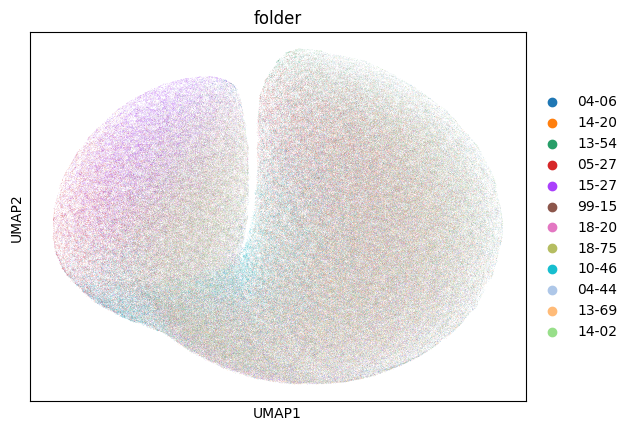

In [ ]:
sc.pp.neighbors(adata, use_rep="latent_representation")
sc.tl.umap(adata)
sc.pl.umap(adata, color="folder")

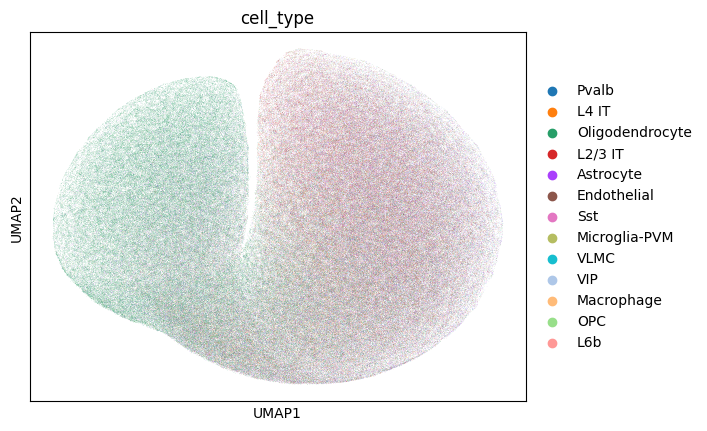

In [347]:
sc.pl.umap(adata, color="cell_type")

In [358]:
sc.tl.leiden(adata, resolution=.1, flavor="igraph", n_iterations=2)

<Axes: >

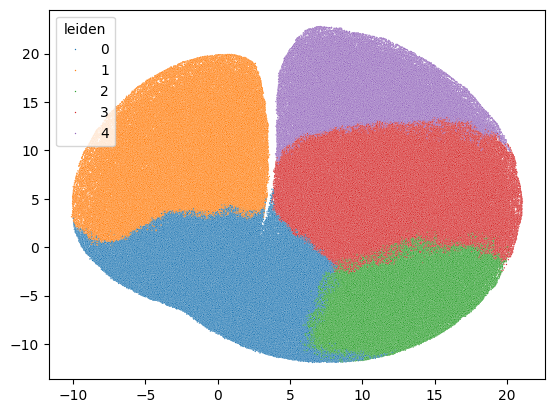

In [359]:
import seaborn as sns
sns.scatterplot(
    x=adata.obsm["X_umap"][:, 0],
    y=adata.obsm["X_umap"][:, 1],
    hue=adata.obs["leiden"], 
    s=1
)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

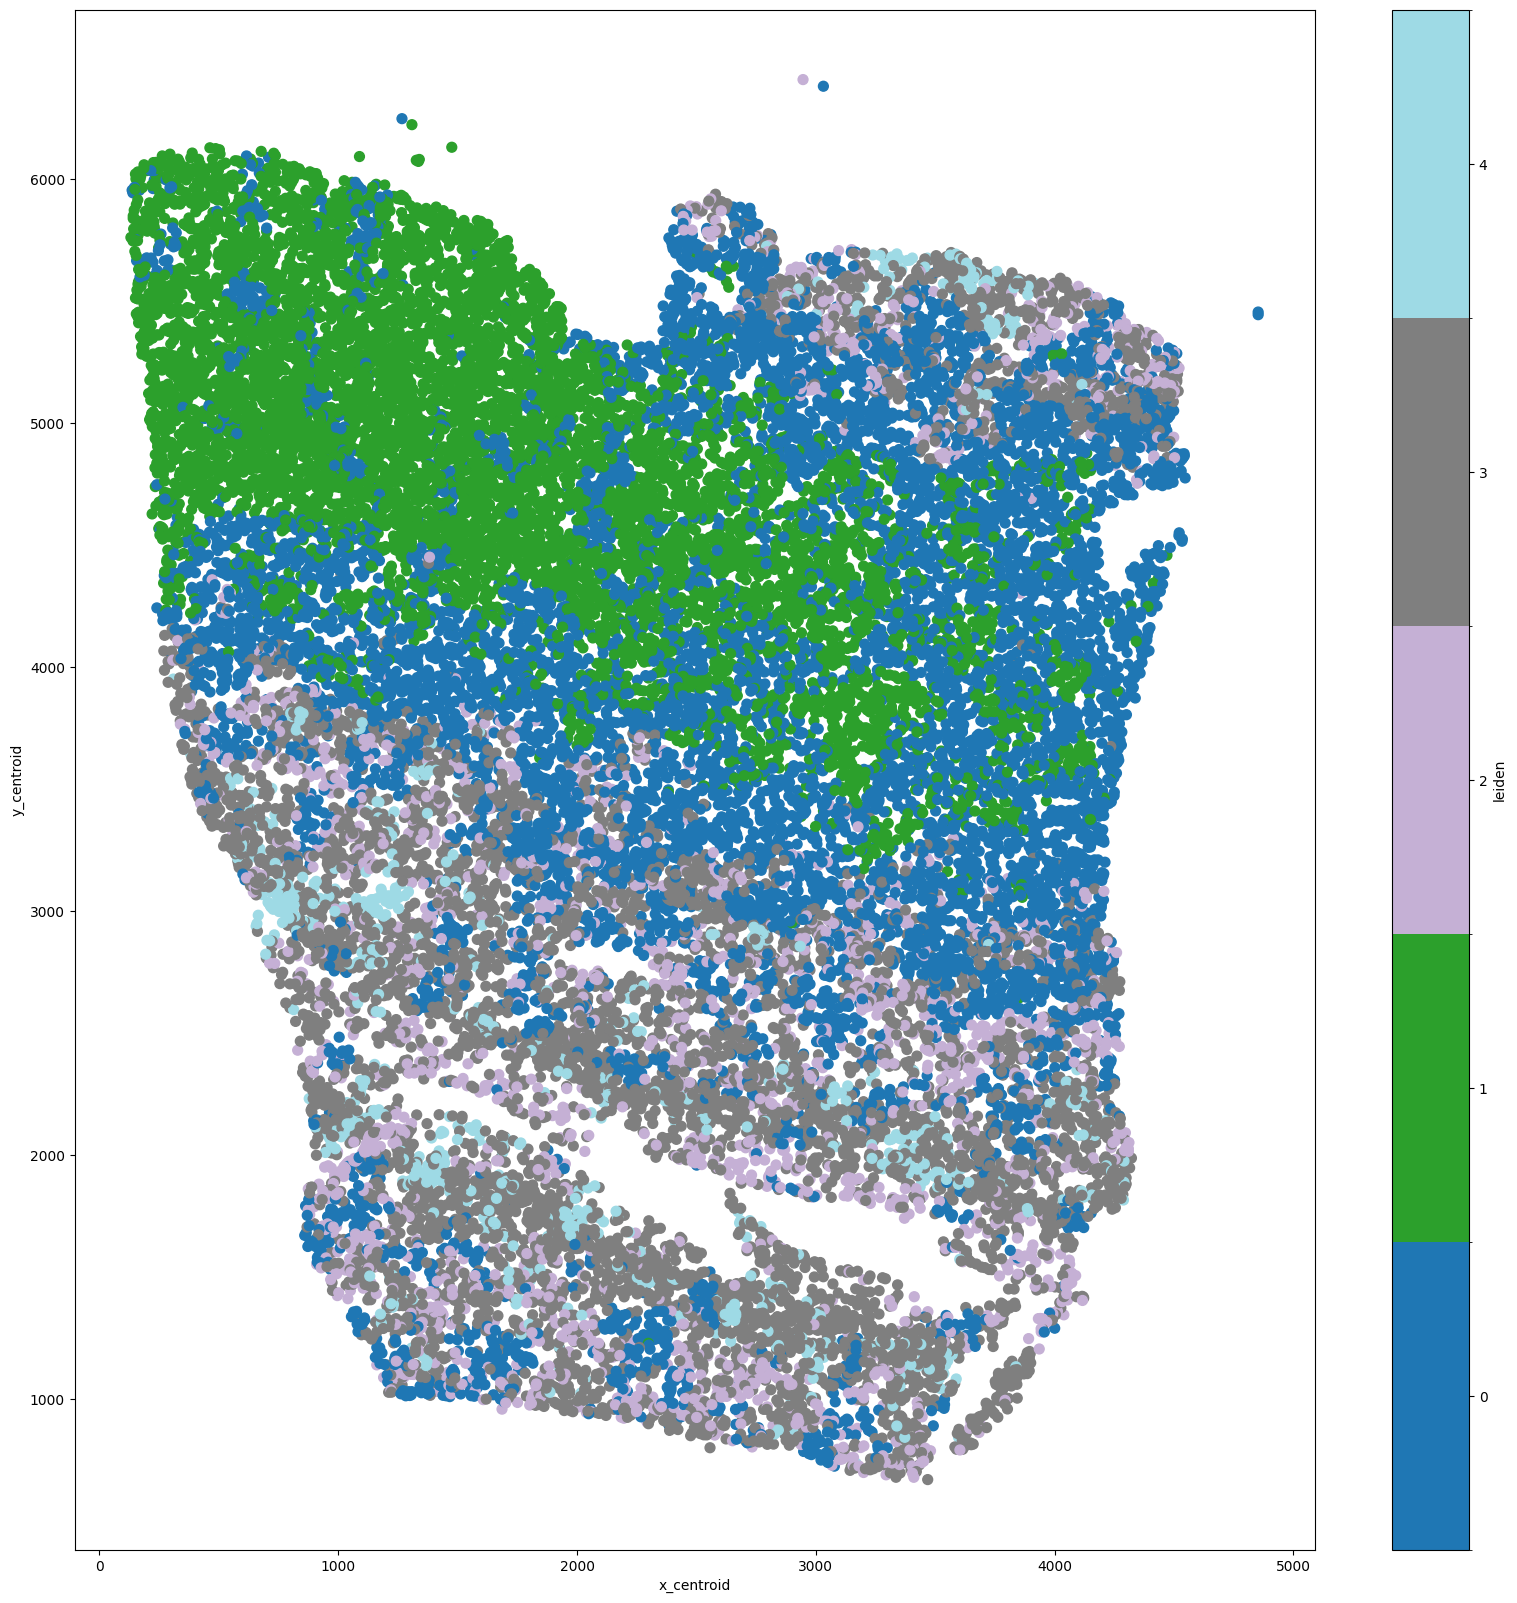

In [360]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
adata[adata.obs["folder"].eq("99-15")].obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    s=50,
    cmap="tab20",
    ax=ax
)

In [361]:
adata.write_h5ad("/home/jhaberbe/Projects/Personal/TokenGT/data/embeddings-8d.h5ad")

In [364]:
torch.save(model, "../model/transformer-8d.pt")

In [366]:
torch.save(vae, "../model/vae-8d.pt")